## 基础定义和导入基础依赖

In [1]:
from LazyProphet import LazyProphet as lp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle as pkl
import polars as pl
import pandas as pd
from collections import defaultdict
import sys
sys.path.append('/home/dell/xyf/azurefunctions-dataset2019/analysis')
from plot import func_load_plot

PROCESSED_12DAYS_DIR = "/home/dell/xyf/azurefunctions-dataset2019/processed/12days/"
DATASET_LENGTH = 12
valid_split_DAY = 9
label_lst = ['Unknown','Warm', 'Regular', "Appro-regular", "Dense", "Successive", "Plused", "Possible", "Corr"]

# 获取WT，假设lst = [0, 1, 1, 0, 0, 1, 1, 1]，count_invok=False，threshold=2 返回[2, 3]
def conj_seq_lst(lst, count_invoke=False, threshold=1):
    seq_lenth_lst = []
    pre_pos = -1
    for i, e in enumerate(lst):
        if not (bool(e) ^ count_invoke): #非异或 判断两个条件是否相等 (求连续正且当前元素为正 或 求连续负且当前元素为负)
            if pre_pos < 0:     #连续序列中的第一个元素位置
                pre_pos = i
            if i == len(lst)-1 and i+1-pre_pos >= threshold:    #末尾元素进行处理
                seq_lenth_lst.append(i+1-pre_pos)
        else:   # 连续序列中断
            if pre_pos>=0 and i-pre_pos >= threshold:
                seq_lenth_lst.append(i-pre_pos)
            pre_pos = -1
    return seq_lenth_lst


class func_state:
    def __init__(self, _type = 0, forget = 0):
        self.type = _type
        self.forget = forget
        
        self.state = False # loaded or not
        self.load_time = None 
        self.wait_time = None 
        self.last_call = None
        self.pre_call_start = None # start of the last calling series
        
        self.idle_info = {} # "mode"：WT mode、 "mode_count": mode 出现次数
        self.invok_info = {}
        self.lasting_info = {}  #

        self.pred_interval = [] # 预测值
        self.pred_value = []
        self.next_invok_start = []
        
        self.adp_wait = []
    
    def load(self, load_time):
        self.state = True
        self.load_time = load_time
    
    def cal_lasting(self, cur_time):
        if not self.state:
            return 0
        return cur_time - self.load_time + 1
    
    def unload(self):
        self.state = False
        self.load_time = None
    
    def cal_wait(self):
        if self.wait_time is None:
            self.wait_time = 0
        self.wait_time += 1
    
    def reset(self, pred=False):
        self.unload()
        self.wait_time = None 
        self.last_call = None
        self.pre_call_start = None
        
        self.adp_wait = []
        
        if pred:
            self.next_invok_start = []


## 读取数据

In [2]:
file_name = "/home/dell/xyf/azure-data/invocations_per_function_md.anon.d"
train_file_names, test_file_names = [file_name+"%02d.csv" % (i) for i in range(1, 13)], [file_name+"13.csv", file_name+"14.csv"]

train_func_arrcount = {}    #函数负载数据
train_func_owner_app = {}   
train_owner_func = defaultdict(set)
train_app_func = defaultdict(set)
func_trigger = defaultdict(set)

for i, file in enumerate(train_file_names):
    df = pd.read_csv(file)
    
    for _, row in df.iterrows():
        func = row["HashFunction"]
        train_func_owner_app[func] = row["HashOwner"]+'\t'+row["HashApp"]
        train_owner_func[row["HashOwner"]].add(func)
        train_app_func[row["HashApp"]].add(func)
        func_trigger[func].add(row["Trigger"])
        
        if func not in train_func_arrcount:
            train_func_arrcount[func] = [0]*12*1440     # 空缺补0
        train_func_arrcount[func][i*1440: (i+1)*1440] = list(row[4:].values)
    del df

test_func_arrcount = {}
test_func_owner_app = {}
test_owner_func = defaultdict(set)
test_app_func = defaultdict(set)

for i, file in enumerate(test_file_names):
    df = pd.read_csv(file)
    
    for _, row in df.iterrows():
        func = row["HashFunction"]
        test_func_owner_app[func] = row["HashOwner"]+'\t'+row["HashApp"]
        test_owner_func[row["HashOwner"]].add(func)
        test_app_func[row["HashApp"]].add(func)
        func_trigger[func].add(row["Trigger"])
        
        if func not in test_func_arrcount:
            test_func_arrcount[func] = [0]*2*1440       # 空缺补0
        test_func_arrcount[func][i*1440: (i+1)*1440] = list(row[4:].values)
    del df

# func_class = {}
# with open("/home/dell/xyf/azurefunctions-dataset2019/mid-data/train_info_assigned.txt") as rf:    # 所有函数的负载数据 hashID  forget  loadarray
#     for line in rf:
#         func, type, forget = line.strip().split('\t')
#         func_class[func] = func_state(_type=type, forget=forget)

# metric_df = pl.read_csv(PROCESSED_12DAYS_DIR+"metric.csv")

# type_list = []
# for func, state in func_class.items():
#     type_list.append((func, state.type))
    
# type_df = pl.DataFrame(type_list, schema=['Function', 'Type'])
# df = metric_df.join(type_df, on='Function')

df = pl.read_csv('func_info.csv')

In [ ]:
# cv_WT_result = []
# for func, arrcount in train_func_arrcount.items():
#     WTs = conj_seq_lst(arrcount)
#     CV_WT = np.std(WTs) / np.mean(WTs)
#     cv_WT_result.append((func, CV_WT))
# df_cv_WT = pl.DataFrame(cv_WT_result, schema=['Function', 'CV_WT'],orient="row")
# print(df_cv_WT)

# now_func_info = pl.read_csv('func_info.csv')
# print(now_func_info)

# print(df)
# df_cv_WT = pl.read_csv('cv_WT.csv')
# df = df.join(df_cv_WT, on='Function')
# print(df)

print(df)



## 周期性函数过滤

In [ ]:
import gc

CV_UPPER_THRESHOLD = 5
CV_LOWER_THRESHOLD = 0.1

PE_THRESHOLD = 0.2
PERIOD_STRENGTH_THRESHOLD = 0.5
CV_WT_THRESHOLD = 2


df = df.filter(pl.col('Type') != 2)   #过滤regular
# cv_df = df.filter(pl.col('CV') < CV_UPPER_THRESHOLD).filter(pl.col('CV') > CV_LOWER_THRESHOLD)
# func_ids = cv_df.select('Function').to_numpy().flatten()
# for func in func_ids:
#     arr = train_func_arrcount[func]
#     plt.figure(figsize=(24,10))
#     x1 = [i for i in range(1, len(arr) + 1)]
    
#     plt.plot(x1, arr, color="blue")
#     func_info = cv_df.filter(pl.col('Function') == func).to_dict(as_series=False)
#     # print(func+'\t'+'Type:{}'.format(label_lst[int(func_info['Type'][0])]))
#     # print("CV:{}\tPE:{}\tPeriod:{}\tPeriod_Strength:{}"
#     #     .format(func_info['CV'][0],func_info['PE'][0],func_info['Period'][0],func_info['Period_Strength'][0]))
    
#     cv = round(func_info["CV"][0],4)
#     pe = round(func_info["PE"][0],4)
#     period = round(func_info["Period"][0],4)
#     ps = round(func_info["Period_Strength"][0],4)
#     plt.text(0.95, 0.90, f'Type: {label_lst[int(func_info["Type"][0])]}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
#     plt.text(0.95, 0.85, f'CV: {cv}      PE: {pe}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
#     plt.text(0.95, 0.80, f'Period: {period}      Period Strength: {ps}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
    
#     # 设置坐标轴刻度标签的大小
#     plt.tick_params(axis='x', direction='out',
#                    labelsize=12, length=3.6)
#     plt.tick_params(axis='y', direction='out',
#                    labelsize=12, length=3.6)
#     # plt.savefig('/home/dell/xyf/azurefunctions-dataset2019/LazyProphet_exp/cv_filter/'+func+'.png')
#     plt.show()
#     plt.clf()


pe_df = df.filter(pl.col('PE') > PE_THRESHOLD)
# pe_df = pe_df.sort('PE')
# print(pe_df.count())
# func_ids = pe_df.select('Function').to_numpy().flatten()
# for func in func_ids[:10]:
#     arr = train_func_arrcount[func]
#     plt.figure(figsize=(16,8))
#     x1 = [i for i in range(1, len(arr) + 1)]
    
#     plt.plot(x1, arr, color="blue")
#     func_info = pe_df.filter(pl.col('Function') == func).to_dict(as_series=False)

#     # print(func+'\t'+'Type:{}'.format(label_lst[int(func_info['Type'][0])]))
#     # print("CV:{}\tPE:{}\tPeriod:{}\tPeriod_Strength:{}"
#     #     .format(func_info['CV'][0],func_info['PE'][0],func_info['Period'][0],func_info['Period_Strength'][0]))
#     cv = round(func_info["CV"][0],4)
#     pe = round(func_info["PE"][0],4)
#     period = round(func_info["Period"][0],4)
#     ps = round(func_info["Period_Strength"][0],4)
#     plt.text(0.95, 0.90, f'Type: {label_lst[int(func_info["Type"][0])]}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
#     plt.text(0.95, 0.85, f'CV: {cv}      PE: {pe}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
#     plt.text(0.95, 0.80, f'Period: {period}      Period Strength: {ps}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
    
#     # 设置坐标轴刻度标签的大小
#     plt.tick_params(axis='x', direction='out',
#                    labelsize=12, length=3.6)
#     plt.tick_params(axis='y', direction='out',
#                    labelsize=12, length=3.6)
#     # plt.savefig('/home/dell/xyf/azurefunctions-dataset2019/LazyProphet_exp/cv_filter/'+func+'.png')
#     plt.show()
#     plt.clf()
    

# period_df = (df.filter((pl.col('Period_Strength') > PERIOD_STRENGTH_THRESHOLD))
#             .filter(~pl.col('Period').is_infinite()).filter(pl.col('CV') > CV_LOWER_THRESHOLD))

cv_WT_df = df.filter((pl.col('CV_WT') > CV_WT_THRESHOLD))\
            .filter((pl.col('CV_WT') < 5))\
            .filter(~pl.col('CV_WT').is_nan())\
            .filter(pl.col('PE')> 0.1)\

df_union = pl.concat([pe_df,cv_WT_df]).unique()
print(df_union)

# cv_WT_df = cv_WT_df.sort("CV_WT")
# print(cv_WT_df)
# func_ids = cv_WT_df.select('Function').to_numpy().flatten()
# selected_ids = func_ids[10:]

# for func in tqdm(selected_ids):
#     arr = train_func_arrcount[func]
#     WTs = conj_seq_lst(arr)
#     print(WTs)
#     print("std:{}\tmean:{}\tcv_WT:{}".format(np.std(WTs),np.mean(WTs),np.std(WTs) / np.mean(WTs)))

#     plt.figure(figsize=(16,8))
#     x1 = [i for i in range(1, len(arr) + 1)]
    
#     plt.plot(x1, arr, color="blue")
#     func_info = cv_WT_df.filter(pl.col('Function') == func).to_dict(as_series=False)

#     # print(func+'\t'+'Type:{}'.format(label_lst[int(func_info['Type'][0])]))
#     # print("CV:{}\tPE:{}\tPeriod:{}\tPeriod_Strength:{}"
#     #     .format(func_info['CV'][0],func_info['PE'][0],func_info['Period'][0],func_info['Period_Strength'][0]))
#     cv = round(func_info["CV"][0],4)
#     pe = round(func_info["PE"][0],4)
#     period = round(func_info["Period"][0],4)
#     ps = round(func_info["Period_Strength"][0],4)
#     cv_WT = round(func_info["CV_WT"][0],4)

#     plt.text(0.95, 0.90, f'Type: {label_lst[int(func_info["Type"][0])]}      CV_WT: {cv_WT}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
#     plt.text(0.95, 0.85, f'CV: {cv}      PE: {pe}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
#     plt.text(0.95, 0.80, f'Period: {period}      Period Strength: {ps}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
    
#     # 设置坐标轴刻度标签的大小
#     plt.tick_params(axis='x', direction='out',
#                 labelsize=12, length=3.6)
#     plt.tick_params(axis='y', direction='out',
#                 labelsize=12, length=3.6)
#     # plt.savefig('/home/dell/xyf/azurefunctions-dataset2019/LazyProphet_exp/cv_WT_filter_2/'+func+'.png')
#     plt.show()
#     plt.clf()
#     plt.close()
# gc.collect() 

# for func in tqdm(func_ids[:10], desc="Processing functions"):
#     print(func)
#     arr = train_func_arrcount[func]
#     plt.figure(figsize=(16,8))
#     x1 = [i for i in range(1, len(arr) + 1)]
    
#     plt.plot(x1, arr, color="blue")
#     func_info = cv_WT_df.filter(pl.col('Function') == func).to_dict(as_series=False)

#     # print(func+'\t'+'Type:{}'.format(label_lst[int(func_info['Type'][0])]))
#     # print("CV:{}\tPE:{}\tPeriod:{}\tPeriod_Strength:{}"
#     #     .format(func_info['CV'][0],func_info['PE'][0],func_info['Period'][0],func_info['Period_Strength'][0]))
#     cv = round(func_info["CV"][0],4)
#     pe = round(func_info["PE"][0],4)
#     period = round(func_info["Period"][0],4)
#     ps = round(func_info["Period_Strength"][0],4)
#     cv_WT = round(func_info["CV_WT"][0],4)

#     plt.text(0.95, 0.90, f'Type: {label_lst[int(func_info["Type"][0])]}      CV_WT: {cv_WT}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
#     plt.text(0.95, 0.85, f'CV: {cv}      PE: {pe}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
#     plt.text(0.95, 0.80, f'Period: {period}      Period Strength: {ps}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',horizontalalignment='right')
    
#     # 设置坐标轴刻度标签的大小
#     plt.tick_params(axis='x', direction='out',
#                 labelsize=12, length=3.6)
#     plt.tick_params(axis='y', direction='out',
#                 labelsize=12, length=3.6)
#     # plt.savefig('/home/dell/xyf/azurefunctions-dataset2019/LazyProphet_exp/cv_WT_filter_2/'+func+'.png')
#     plt.show()
#     plt.clf()
#     plt.close()
# gc.collect() 


## 误差指标以及滑动预测定义

In [4]:
from sklearn.preprocessing import MinMaxScaler
import time

# func_ids = ['8e8a52ada035bc6cf4de91c8793add793325684eb57235f7cee6d8ded348d01e',
#                 '1d8f4a33ef584c9396a70cb3c5e1f71e4d847e1d345c03fe6c41306af9d07099',
#                 'e79fff2fdf4c23cd6c1e2e09e73bfb29ad15d05fea859eb1a11f603247dd7b2d',
#                 'b3543c1d08ef66ff13e0df698e0e9615e4a497ace232c3715779151427fe15d5',
#                 'e370dfc0407dec1f01bd6318b1da2433550d901d1410efc5be13d5125f81ab6d',
#                 '69c500c02979aad7251a896443f0351f17fda907b2a725fa64dfa3dfaf033e18',
#                 '5eadc93e1f21871e5b6f0dad42568cd7ac1686845442351762e37df3d843d78e',
#                 '41d5874c93e42b71124b2cc6439e6f6fdb5920e67163eebef372593b878741f8',
#                 '4a7dd1ef6093fd18d6476fd9426b4c7c99dbc7841c410504944ae18fad2640f2',
#                 'f1de419dc75ea0f629deaf936e0b65934cbf2bc444ffd7b3116e3a19dd108f11',
#                 '5b0d972219faa458acb5feb4f0789281be007552960ca6a68c062ef8a5f205c1',
#                 '9680d492f74f5227698a669a4805fc8577d47fbaa7da95dacd6fcb2ffaf58d42',
#                 'eb8de460611a65172fda55679873c739ce67592e478bf6b773e1919fa138eaf5',
#                 '5336bda8faa5d11baac08b366930d5a0f89d37430f6df30028d75e7fb9724b3e',
#                 '07cbff1ae225244f3c6bb9ed4bc1375fa762be6e097b3b62b862dc41ef3380ce',
#                 '22072b261570f0452b5c8ae0cbe6e52c38ec68f19f1276535d87d02d7e085275',
#                 'be58d43a3cd2c049eccfed0f645eff89d278fc1b45e7a08a9278c02e6214ec36',
#                 '96b14a4f4e75557932044a3728918aa04102f9aa1dcd6e5ae8fd0e77b68b3dbf',
#                 '0e205a2068ab2ffe80f5297bc77f2a9a60341394575a05a2114ec58f6926a1e1',
#                 '3f028fd2cab9475007b3cff8fce6acbfb9c9e8f277afb98a5b6b86a77207bf7c']

func_ids = ['0a2bf24aad6c3f22d4c93a7e7a17d4261fd75ef1043698cdc76b5293d60f2e37',
            '0a3f7a5a41897e798fe77364e5fe9069cc9e49f88b0cbb7709583b6d316425ce',
            '0a05f4ed978226df2ea80aa7fe9709565a5fbbe86c67619b25903bbd5d7a38b7',
            '0b0a77044db1203f41fde555aca7260fd8eb4a194e149d3608cf6fe614d69066',
            '3ee48afa7433ca36705cf1de34c3e01508f891494a58e20de3926b604e503a5d',
            '0b5a81f20febd497bab562ea315adcc95e0c64bdcc6e1cf493faed0d479adaf7',
            '0b79e31ba1010a8fc227234a0b7c20b8f9938cc3bb01d72bfa74e5dc7d16ef2d',
            '0affafe05ecaf365c7ff5af7b20eecaab7438ca37e544242522af9858a1468e0',
            '0b45207bf46f953509b81b7fbf0df8d4163d940b0eb4da40238381018aedae1c',
            '0c5d2d849802cf3d72bc4196fe11194b4be0e40187d136b863a021e733467732',
            '1b3bb5f765c2688f8fe609ff217de8ae852957a8ce629b35b0e79cd6194b9a0c',
            '0b4a02def7fd092fd832c0c93bcedc4692657bc46856128102d0d9fc5135e4ea',
            '0b87437bfd30959c1324295a991fb10e5fb23ed7a0c5d388d31266bceeee0098',
            '0ba17de49e52a61feb0387514cc43d3c4a6cd81c78f71f121d5b2763c9df07e4',
            '7ef3e326424ae81979f934174564ad7539e9241895fc5527fcd6e2b02f9ca376',
            '0b35e6779bcc7a254461d1d35090fef2bf14305d303957da1cbc62e03ea9d1f1',
            '0b54e8dcc3be570e3327fd371e351b71f11fefa1566d0488e3e00aeecb83260b',
            '0bb0a628699ef20450f3cdd35c9b43a973fe84c722f7210ca0dd9dd857befa89',
            '0cdb1be0c51ad64fbbb29a79054cc97add9bf65d6dac077e2aee9a4e083e5dbe',
            '0e7d3f107c7d81d8ed6269cc6e5332d701c87bd4b17ad5d0e788672db664c446',
            '0e84de2b676f4e1bb80cbf72c5062e11bf3f0331860f0460b72ebcdc52543087',
            '0f83920d4c438fdf3e814aa24a23fda73d5efd0604af7fea7d85d125d4083609',
            '0faf768b12d32974470c17014501d5aa47af963c20cc2ebe4a0f5d9318d211b8',
            '3ea752d4544b3df15bac8057b9270c531823583a0ed4682134e46fb17b04cfb6',
            '5e98666f0af3fee4a98e670ab893ddf57046816b30775e3decd77a098d317e98',
            '5f8204c622e5f08709ed85aefdcc02f4f9ac8991a747aa4b2d61d9f113123ade',
            '6ebf7f0531f610032fafaec9da2b0e701217aa2cff14a1c4cbf81c788e8bbbbb',
            '6f082405f22de6a4565902fa05f721b42223311af93dedcce96f907654fb45c9',
            '07dd21ddcfb3cffecb5eeb04de71d3e6c4d67bfc27ff1ba4f2df96a543546166',
            '7c0e591a3aef826f584c4d19015d245d574571e8a31eda3b14667966288c2624',
            '7f60d4c90d623b2d4d30b4df58f951c244637371ac93bcfd36374b7a82121f5d']

# MAE (平均绝对误差)
def mae(y_true, y_pred):
    result = np.mean(np.abs(y_true - y_pred))
    return round(result,3)

# MSE (均方误差)
def mse(y_true, y_pred):
    result = np.mean((y_true - y_pred) ** 2)
    return round(result, 3)

# sMAPE (对称平均绝对百分比误差)
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    smape_value = np.mean(np.abs(y_pred - y_true) / (denominator + 1e-10))
    return round(smape_value, 3)

# RMSE (均方根误差)
def rmse(y_true, y_pred):
    result = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return round(result, 3)

def sliding_window_prediction(model, train_data, valid_data, local_window, predict_window):
    valid_size = len(valid_data)
    predictions = []
    extended_train_data = np.copy(train_data)
    total_time = 0  # 用于记录总时间
    prediction_count = 0  # 记录预测的次数

    for start in range(0, valid_size, predict_window):
        # Update training data by including part of the validation data
        window_data = np.concatenate((extended_train_data, valid_data[:start]))

        if len(window_data) > local_window:
            window_data = window_data[-local_window:]

        start_time = time.time()  # 记录开始时间
        model.fit(window_data)
        pred = model.predict(predict_window).flatten()
        end_time = time.time()  # 记录结束时间

        # 本次预测用时
        prediction_time = end_time - start_time
        total_time += prediction_time
        prediction_count += 1

        pred = list(map(lambda x: round(x) if x > 0 else 0, pred))
        predictions.extend(pred)
    #平均用时
    average_time = total_time / prediction_count if prediction_count > 0 else 0
    return predictions, average_time


## 预测

In [13]:

LOCAL_WINDOW = 60*48
PREDICT_WINDOW = 30

# LighGBM 的参数
boosting_params = {
                        "objective": "regression",
                        "metric": "mape",
                        "verbosity": -1,
                        "boosting_type": "gbdt",
                        "seed": 42,
                        "learning_rate": 0.1,
                        "min_child_samples": 4,
                        "num_leaves": 128,
                        "num_iterations": 100
                                    }
pred_func_account = {}

with tqdm(total=len(func_ids)) as pbar:
    for func in func_ids:
        lp_model = lp.LazyProphet(scale=True,
                        seasonal_period=[24, 168],
                        n_basis=8,
                        fourier_order=10,
                        ar=list(range(1, 97)),
                        decay=.99,
                        linear_trend=None,
                        decay_average=False,
                        boosting_params=boosting_params
                        )
        
        arr = train_func_arrcount[func]
        train_arr, valid_arr = arr[:1440 * valid_split_DAY], arr[1440 * valid_split_DAY:]
        pred_result, avg_time = sliding_window_prediction(lp_model, train_arr, valid_arr, LOCAL_WINDOW, PREDICT_WINDOW)
        pred_func_account[func] = pred_result
        pbar.update(1)

with open('specific_func_pred30mins.pkl', 'wb') as f:
    pkl.dump(pred_func_account, f)

100%|██████████| 31/31 [50:42<00:00, 98.15s/it] 


## 预测效率

In [ ]:
# LighGBM 的参数
boosting_params = {
                        "objective": "regression",
                        "metric": "mape",
                        "verbosity": -1,
                        "boosting_type": "gbdt",
                        "seed": 42,
                        "learning_rate": 0.1,
                        "min_child_samples": 4,
                        "num_leaves": 128,
                        "num_iterations": 100
                                    }
pred_func_account = {}
for LOCAL_WINDOW in range(60*6, 60*48+1, 60*6):
    for PREDICT_WINDOW in range(15, 60*2+1, 15):
        lp_model = lp.LazyProphet(scale=True,
                seasonal_period=[24, 168],
                n_basis=8,
                fourier_order=10,
                ar=list(range(1, 97)),
                decay=.99,
                linear_trend=None,
                decay_average=False,
                boosting_params=boosting_params
                )
        arr = train_func_arrcount['8e8a52ada035bc6cf4de91c8793add793325684eb57235f7cee6d8ded348d01e']
        train_arr, valid_arr = arr[:1440 * valid_split_DAY], arr[1440 * valid_split_DAY:]
        pred_result, average_time = sliding_window_prediction(lp_model, train_arr, valid_arr, LOCAL_WINDOW, PREDICT_WINDOW)
        pred_func_account[func] = pred_result
        print('input:{}_predict:{}\tcost:{}'.format(LOCAL_WINDOW,PREDICT_WINDOW,average_time))


## 输入输出窗口长度评估

In [ ]:
MAEs = []
MSEs = []
sMAPEs = []
RMSEs = []

LOCAL_WINDOW = 1440
for PREDICT_WINDOW in range(15, 60*2+1, 15):
    with open('{}_{}.pkl'.format(LOCAL_WINDOW, PREDICT_WINDOW),'rb') as f:
        pred_func_account = pkl.load(f)
    # func_info = df.filter(pl.col('Function') == func).to_dict(as_series=False)
    # print()
    # print(func+'\t'+'Type:{}'.format(label_lst[int(func_info['Type'][0])]))
    # print("CV:{}\tPE:{}\tPeriod:{}\tPeriod_Strength:{}"
    #     .format(func_info['CV'][0],func_info['PE'][0],func_info['Period'][0],func_info['Period_Strength'][0]))
    print('Predict Windows:{}'.format(PREDICT_WINDOW))
    for func in func_ids:
        scaler = MinMaxScaler()
        pred_result = np.array(pred_func_account[func],dtype=int)
        
        arr = train_func_arrcount[func]
        # print(arr[:30])

        train_arr = np.array(train_func_arrcount[func][:1440 * valid_split_DAY],dtype=int)
        valid_arr = np.array(train_func_arrcount[func][1440 * valid_split_DAY:],dtype=int)

        valid_normalized = scaler.fit_transform(np.array(valid_arr).reshape(-1,1))
        pred_normalized = scaler.transform(np.array(pred_result).reshape(-1,1))[:4320]
        
        # 计算MAE、MSE、RMSE、sMAPE
        result_MAE = mae(valid_normalized, pred_normalized)
        result_MSE = mse(valid_normalized, pred_normalized)
        result_sMAPE = smape(valid_normalized, pred_normalized)
        result_RMSE = rmse(valid_normalized, pred_normalized)
        
        # 输出函数信息
        # func_info = df.filter(pl.col('Function') == func).to_dict(as_series=False)
        # print(func+'\t'+'Type:{}'.format(label_lst[int(func_info['Type'][0])]))
        # print("CV:{}\tPE:{}\tPeriod:{}\tPeriod_Strength:{}"
        #     .format(func_info['CV'][0],func_info['PE'][0],func_info['Period'][0],func_info['Period_Strength'][0]))
        # print("Predict Windows:{}\tMAE:{}\tMSE:{}\tRMSE:{}\tsMAPE:{}".format(PREDICT_WINDOW,result_MAE, result_MSE, result_RMSE, result_sMAPE))

        MAEs.append(result_MAE)
        MSEs.append(result_MSE)
        sMAPEs.append(result_sMAPE)
        RMSEs.append(result_RMSE)

    mean_MAE = np.mean(MAEs)
    mean_MSE = np.mean(MSEs)
    mean_RMSE = np.mean(sMAPEs)
    mean_sMAPE = np.mean(RMSEs)

    print("MAE:{}\tMSE:{}\tRMSE:{}\tsMAPE:{}".format(mean_MAE, mean_MSE, mean_RMSE, mean_sMAPE))
    # print("MAE:{}\tMSE:{}\tRMSE:{}\tsMAPE:{}".format(MAEs[6], MSEs[6], RMSEs[6], sMAPEs[]))
    print('')

        # # 画图
        # plt.rcParams['axes.unicode_minus'] = False        # 显示负号
        # plt.figure(figsize=(16,8))
        # x1 = [i for i in range(1, len(arr) + 1)]
        # x2 = [i for i in range(len(train_arr), len(train_arr) + len(valid_arr))]
            
        # # plt.plot(x1, arr, color="blue")
        # # plt.plot(x2, pred_result, color="red", label="Actual")
        # plt.axvline(len(train_arr), color="#00FF3A", label="Forecast")
            
        # # 设置坐标轴刻度标签的大小
        # plt.tick_params(axis='x', direction='out',
        #                 labelsize=12, length=3.6)
        # plt.tick_params(axis='y', direction='out',
        #                 labelsize=12, length=3.6)
        # plt.show()
        # plt.clf()




0a2bf24aad6c3f22d4c93a7e7a17d4261fd75ef1043698cdc76b5293d60f2e37	Type:Appro-regular
CV:3.7416573867739418	PE:0.27067539736943447	Period:15.0	Period_Strength:0.0936444578450476	CV_WT:0.03135611235968077
Predict Windows:60mins	MAE:0.035	MSE:0.035	RMSE:0.187	sMAPE:0.07


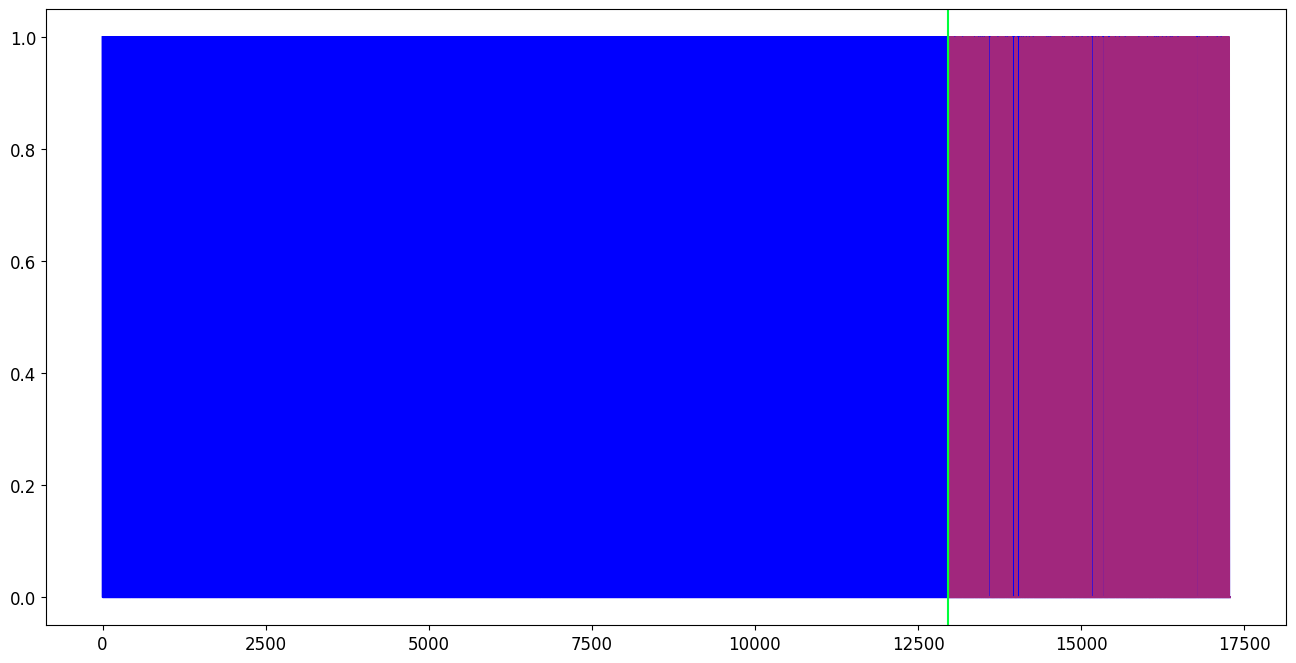

Predict Windows:30mins	MAE:0.026	MSE:0.026	RMSE:0.162	sMAPE:0.052


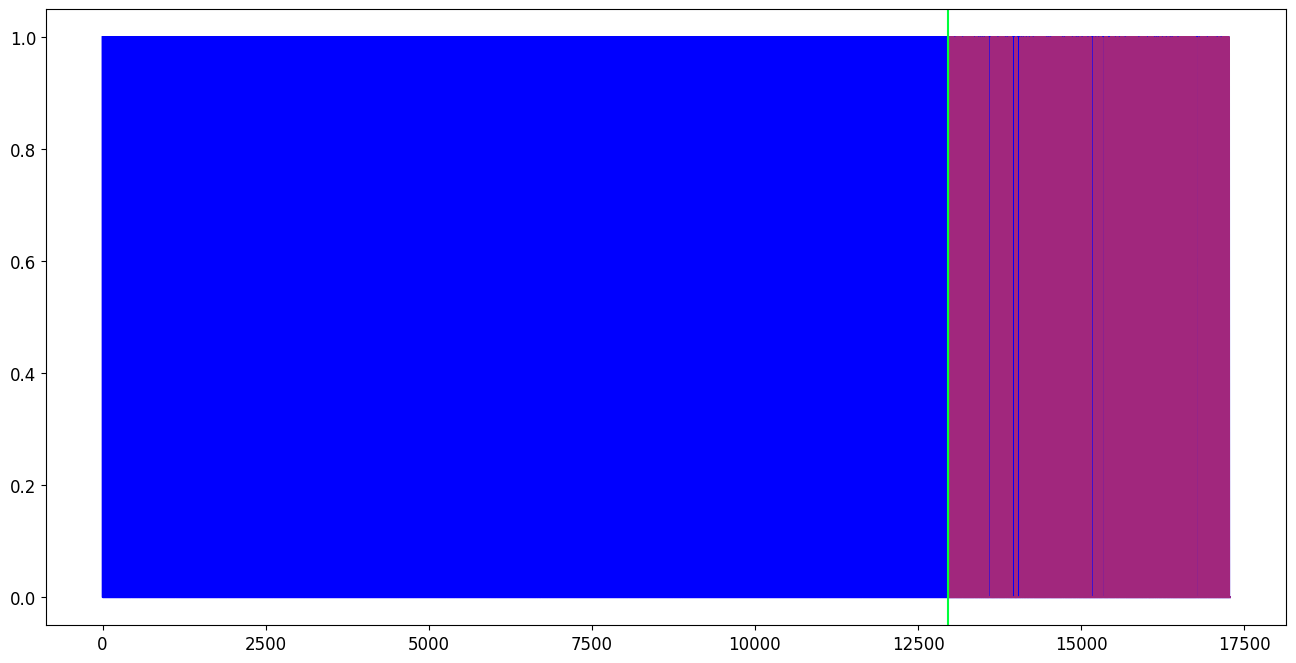

0a3f7a5a41897e798fe77364e5fe9069cc9e49f88b0cbb7709583b6d316425ce	Type:Appro-regular
CV:2.7826172692058844	PE:0.3963132980551356	Period:5.0	Period_Strength:0.21496512399948847	CV_WT:14.63194512123589
Predict Windows:60mins	MAE:0.0	MSE:0.0	RMSE:0.0	sMAPE:0.0


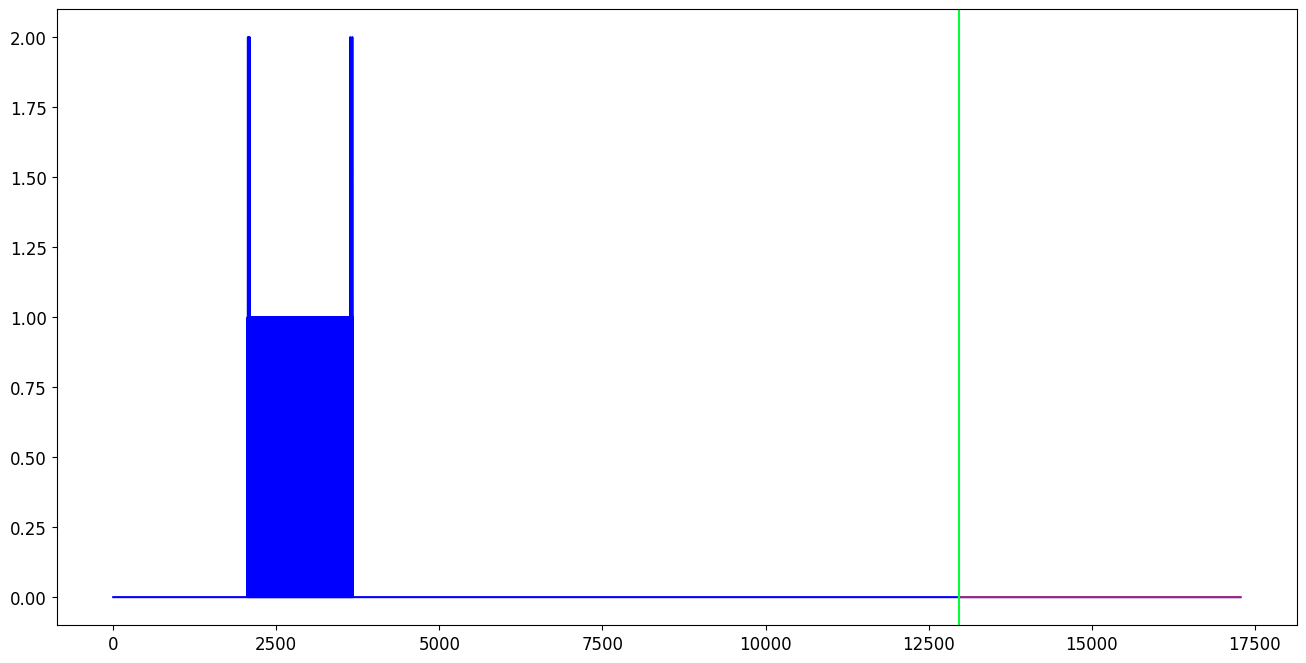

Predict Windows:30mins	MAE:0.0	MSE:0.0	RMSE:0.0	sMAPE:0.0


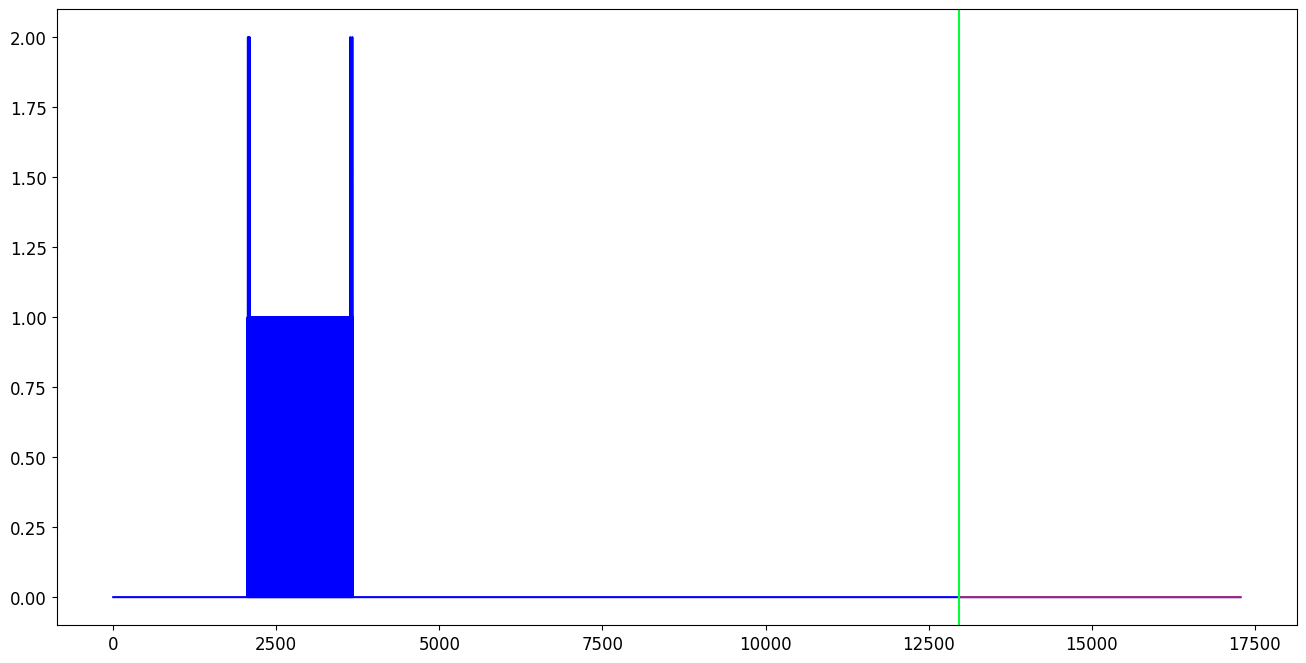

0a05f4ed978226df2ea80aa7fe9709565a5fbbe86c67619b25903bbd5d7a38b7	Type:Appro-regular
CV:1.734698054138553	PE:0.5818265839903222	Period:4.0	Period_Strength:0.27728778309109964	CV_WT:0.19719498900753657
Predict Windows:60mins	MAE:0.102	MSE:0.051	RMSE:0.226	sMAPE:0.408


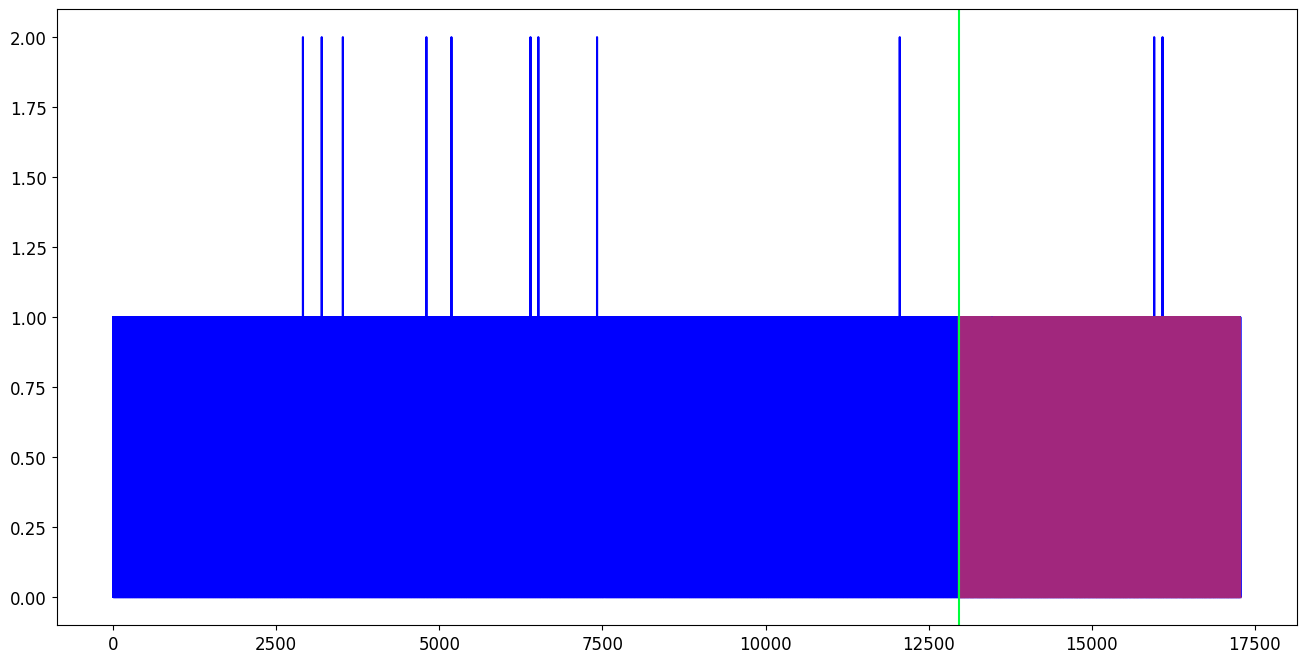

Predict Windows:30mins	MAE:0.105	MSE:0.053	RMSE:0.23	sMAPE:0.421


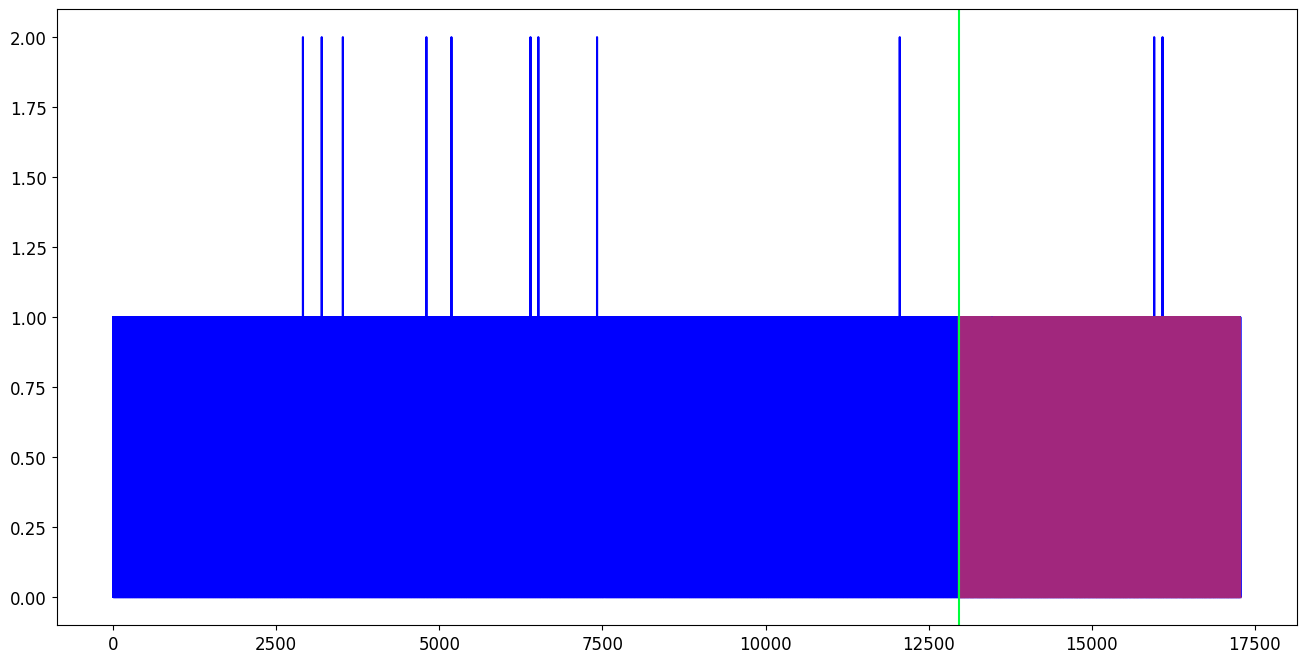

0b0a77044db1203f41fde555aca7260fd8eb4a194e149d3608cf6fe614d69066	Type:Appro-regular
CV:1.2921075410880387	PE:0.008751818886076965	Period:1439.9999999999998	Period_Strength:0.4919865931954425	CV_WT:0.816840151984769
Predict Windows:60mins	MAE:0.044	MSE:0.022	RMSE:0.148	sMAPE:0.202


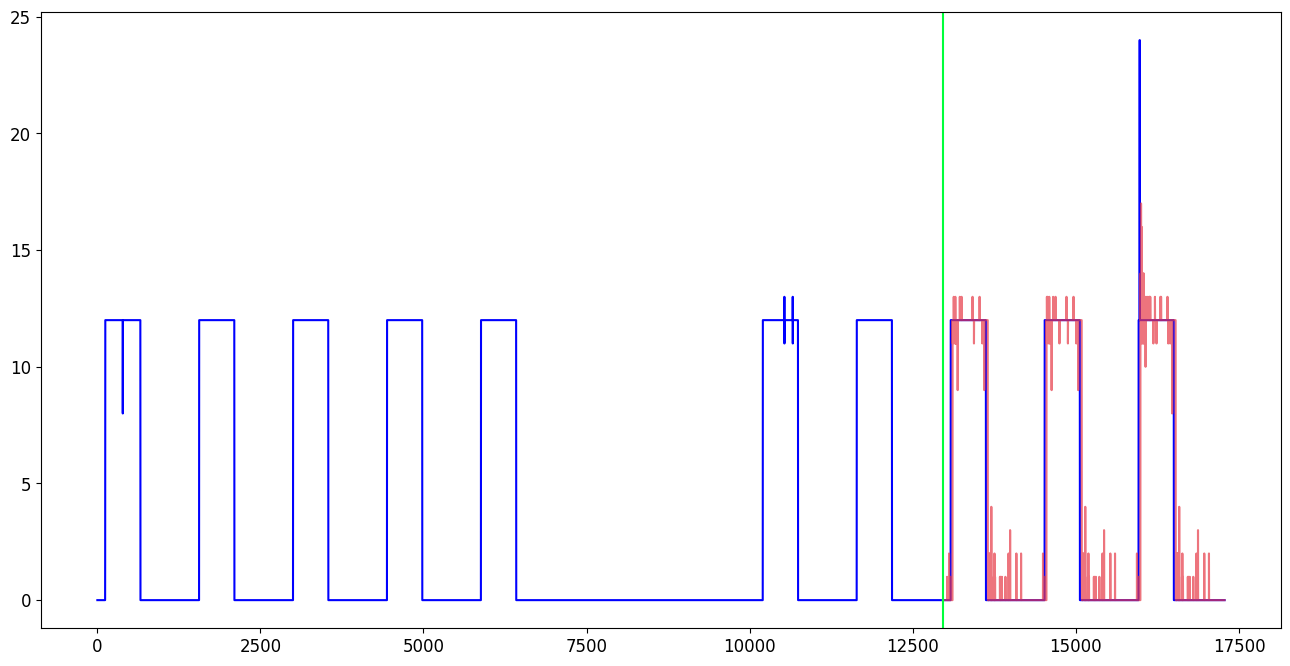

Predict Windows:30mins	MAE:0.024	MSE:0.011	RMSE:0.107	sMAPE:0.132


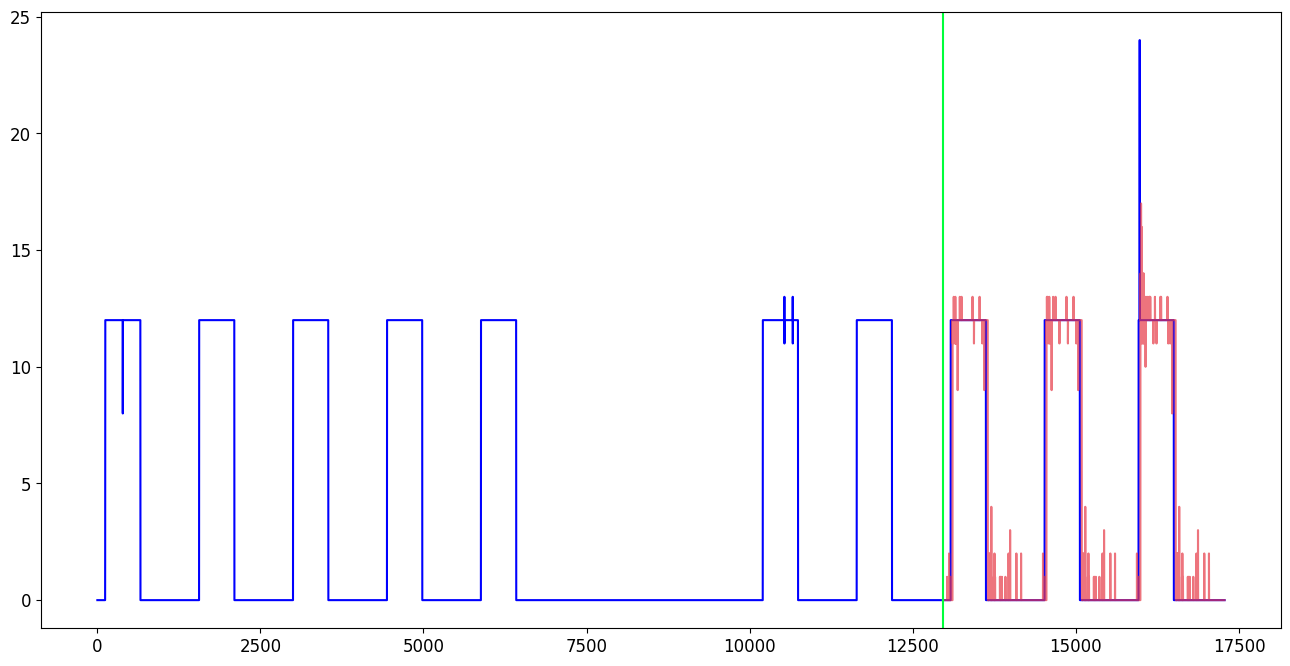

3ee48afa7433ca36705cf1de34c3e01508f891494a58e20de3926b604e503a5d	Type:Possible
CV:2.4338728044742686	PE:0.3299580170815833	Period:8640.0	Period_Strength:0.1828106593458168	CV_WT:2.6055601312606407
Predict Windows:60mins	MAE:0.187	MSE:0.112	RMSE:0.335	sMAPE:0.678


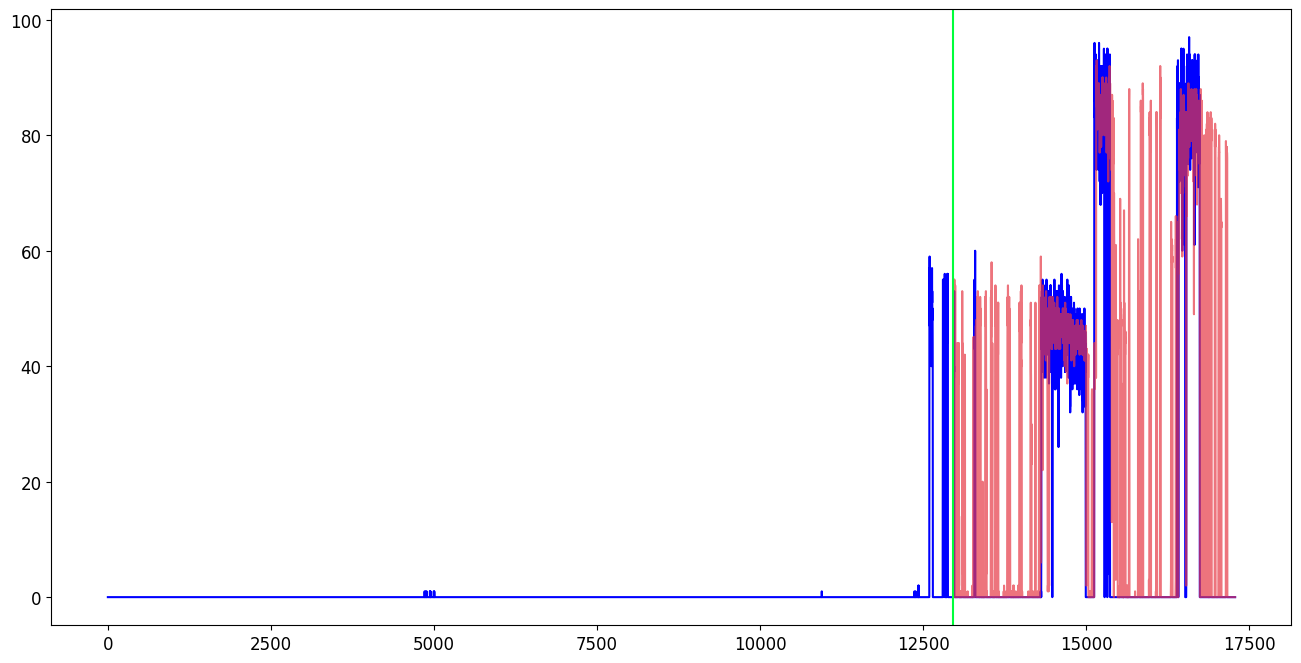

Predict Windows:30mins	MAE:0.142	MSE:0.085	RMSE:0.291	sMAPE:0.517


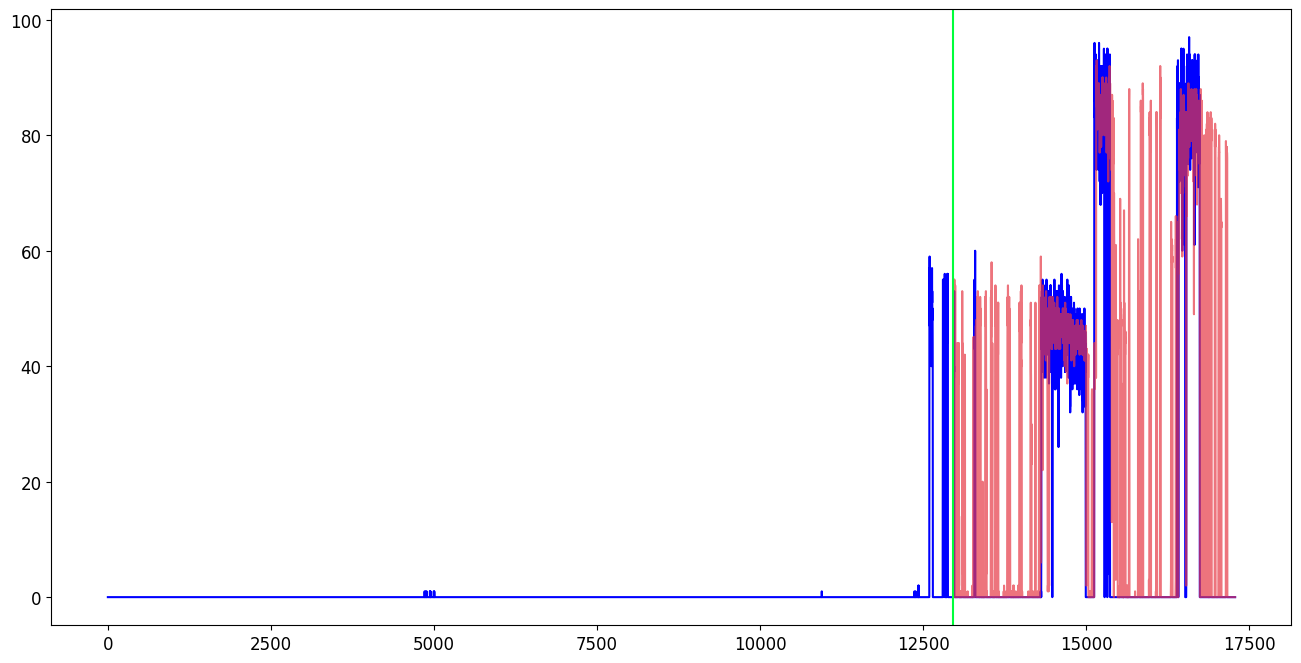

0b5a81f20febd497bab562ea315adcc95e0c64bdcc6e1cf493faed0d479adaf7	Type:Appro-regular
CV:0.8435177897940708	PE:0.7743679211851555	Period:7200.0	Period_Strength:0.48094250867033606	CV_WT:2.9972632731253417
Predict Windows:60mins	MAE:0.028	MSE:0.008	RMSE:0.092	sMAPE:0.093


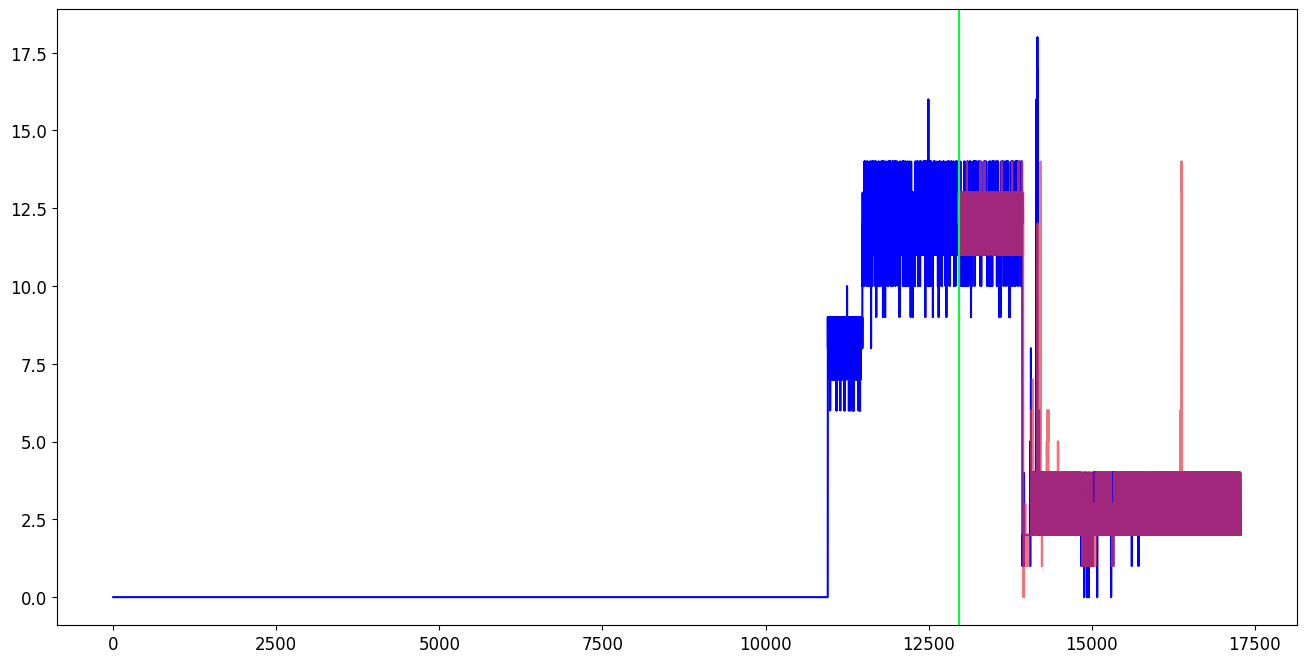

Predict Windows:30mins	MAE:0.023	MSE:0.006	RMSE:0.074	sMAPE:0.083


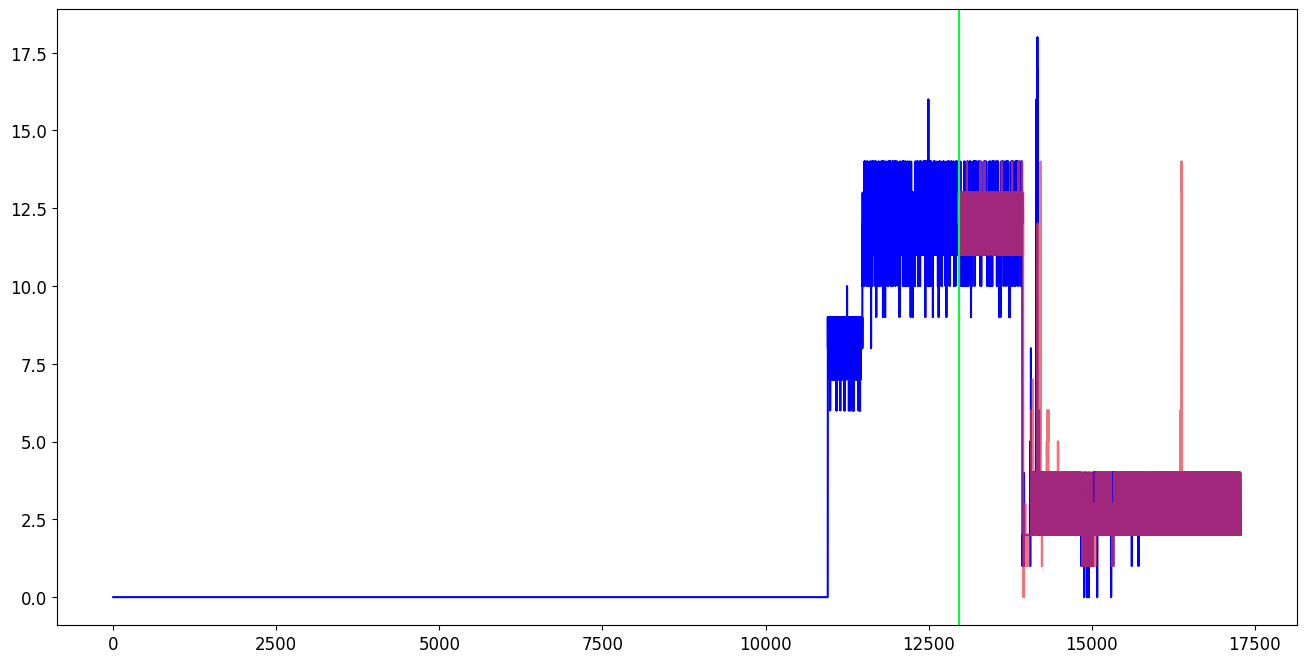

0b79e31ba1010a8fc227234a0b7c20b8f9938cc3bb01d72bfa74e5dc7d16ef2d	Type:Successive
CV:0.32020654670806575	PE:0.0995657956428249	Period:inf	Period_Strength:0.47210464158415594	CV_WT:0.0
Predict Windows:60mins	MAE:0.018	MSE:0.003	RMSE:0.058	sMAPE:0.023


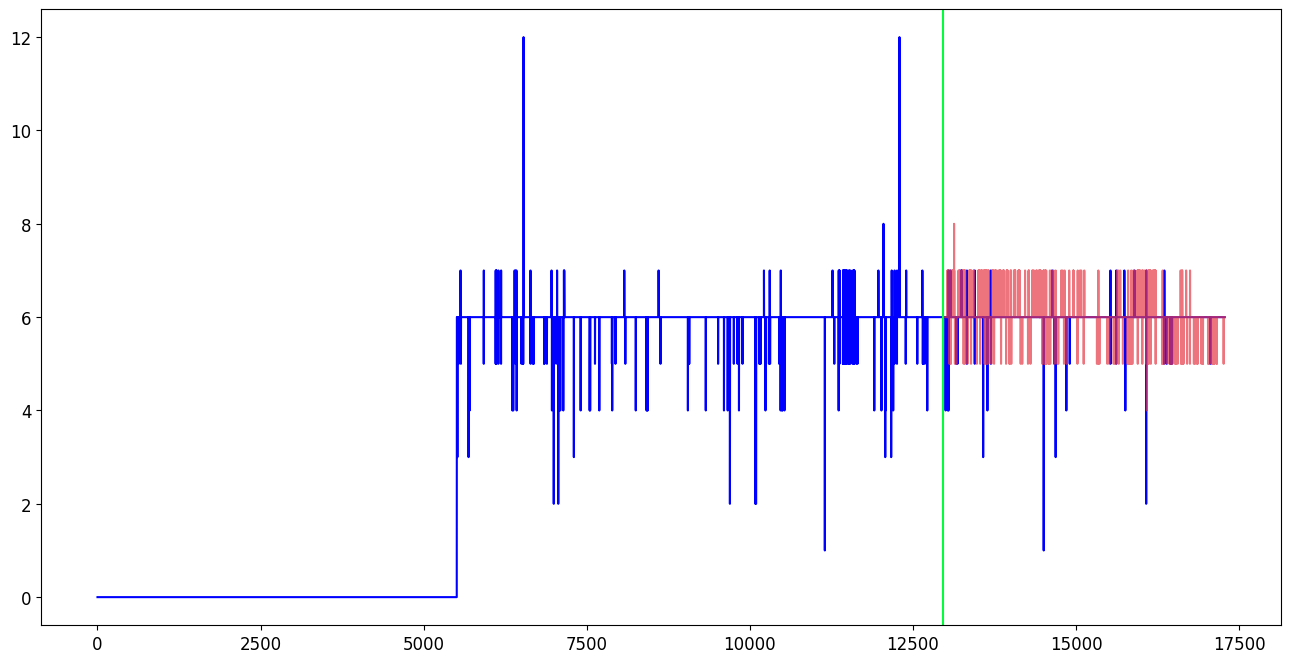

Predict Windows:30mins	MAE:0.014	MSE:0.003	RMSE:0.052	sMAPE:0.017


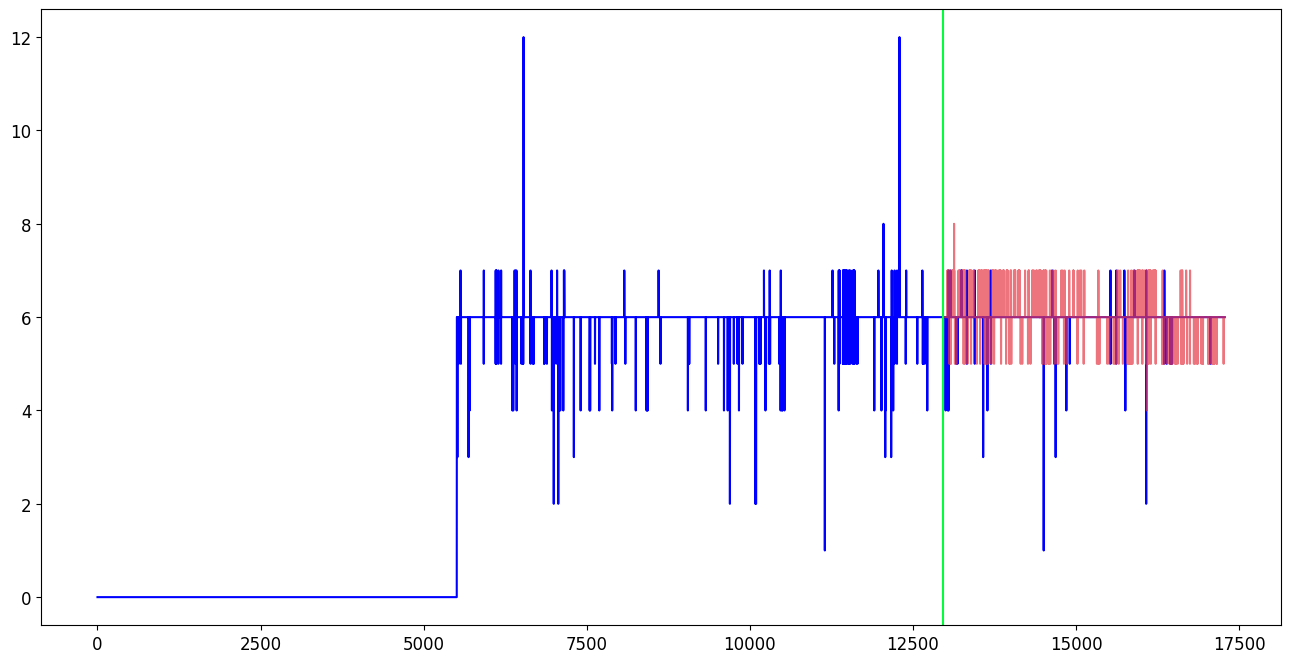

0affafe05ecaf365c7ff5af7b20eecaab7438ca37e544242522af9858a1468e0	Type:Successive
CV:0.7168313483191613	PE:0.6463548657818734	Period:10080.0	Period_Strength:0.512039306704323	CV_WT:0.0
Predict Windows:60mins	MAE:0.174	MSE:0.106	RMSE:0.326	sMAPE:0.619


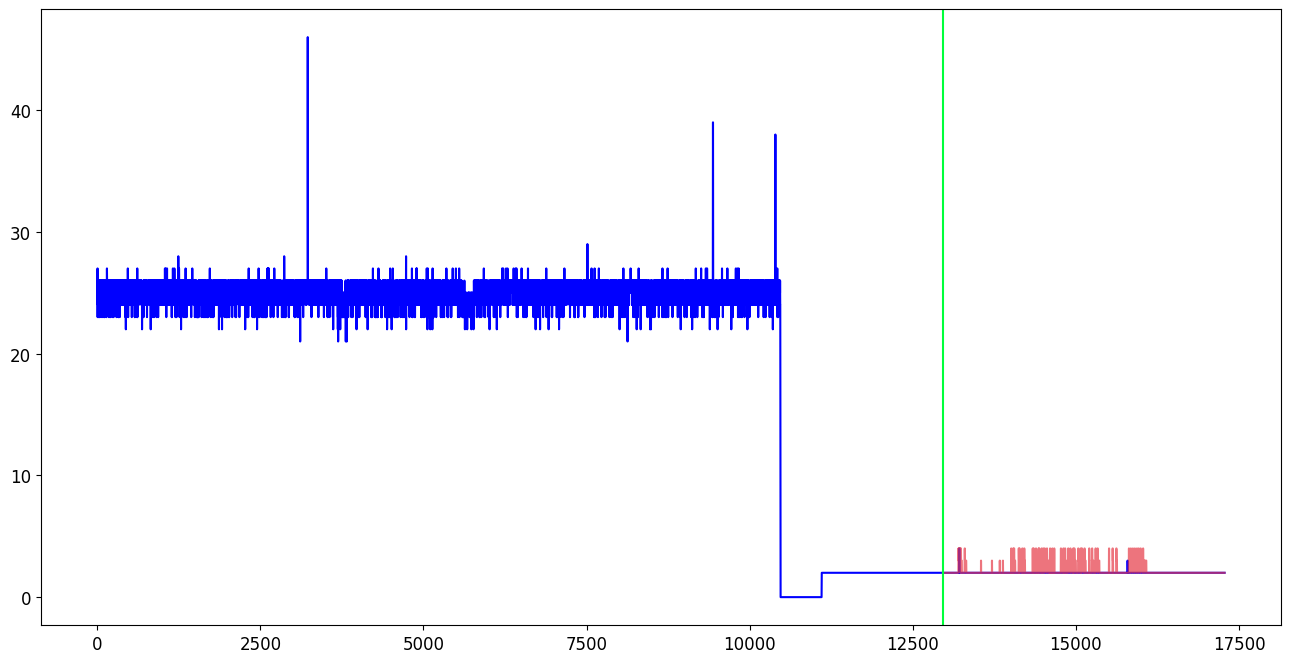

Predict Windows:30mins	MAE:0.126	MSE:0.084	RMSE:0.29	sMAPE:0.417


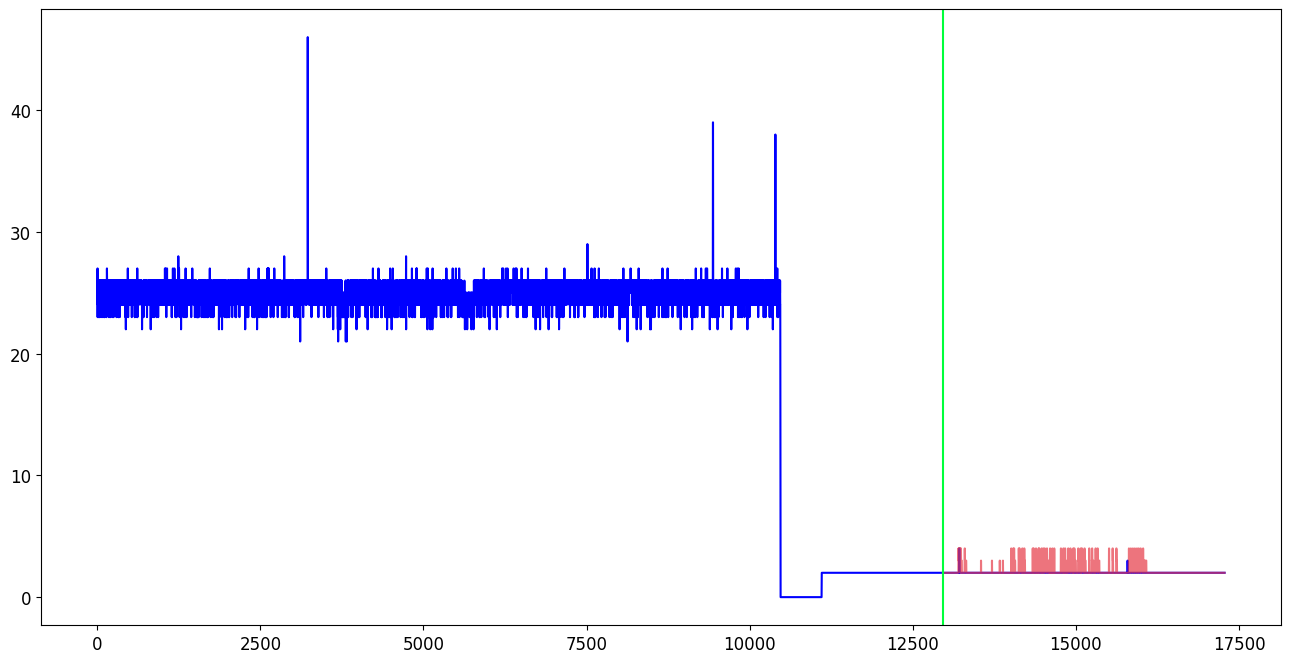

0b45207bf46f953509b81b7fbf0df8d4163d940b0eb4da40238381018aedae1c	Type:Appro-regular
CV:1.2613094551055848	PE:0.9367679813532617	Period:10080.0	Period_Strength:0.5103989307463245	CV_WT:3.5409619049911676
Predict Windows:60mins	MAE:0.016	MSE:0.008	RMSE:0.09	sMAPE:0.06


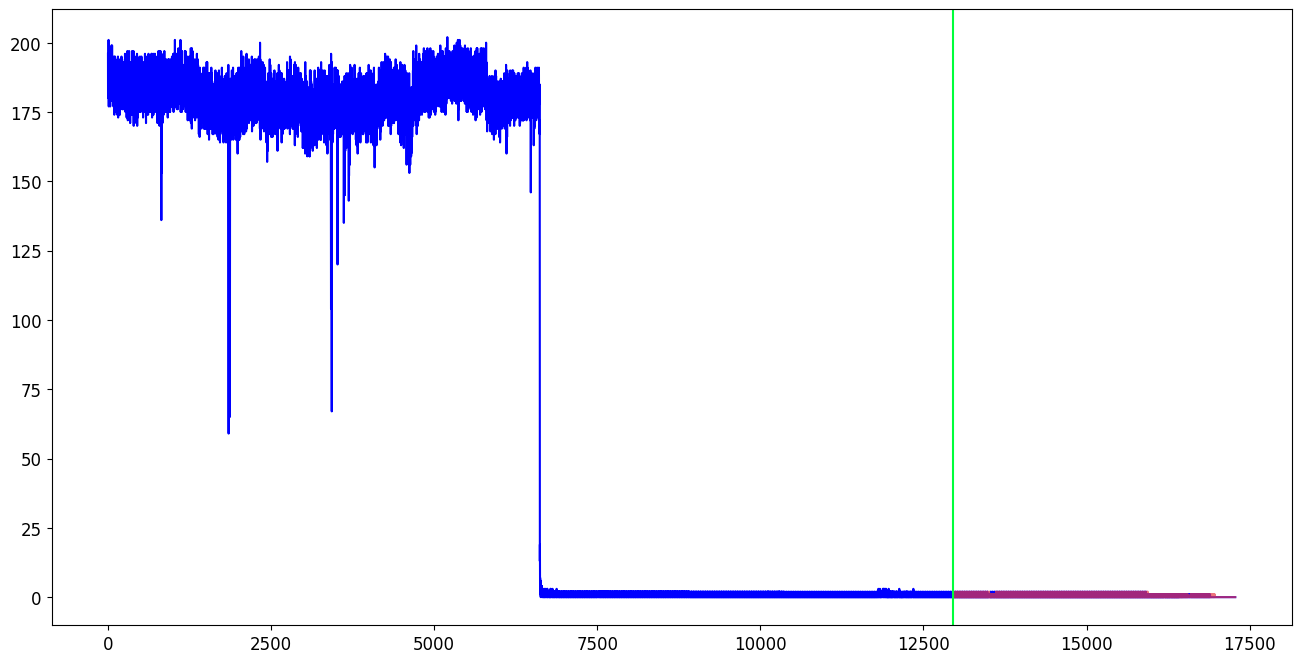

Predict Windows:30mins	MAE:0.014	MSE:0.007	RMSE:0.085	sMAPE:0.054


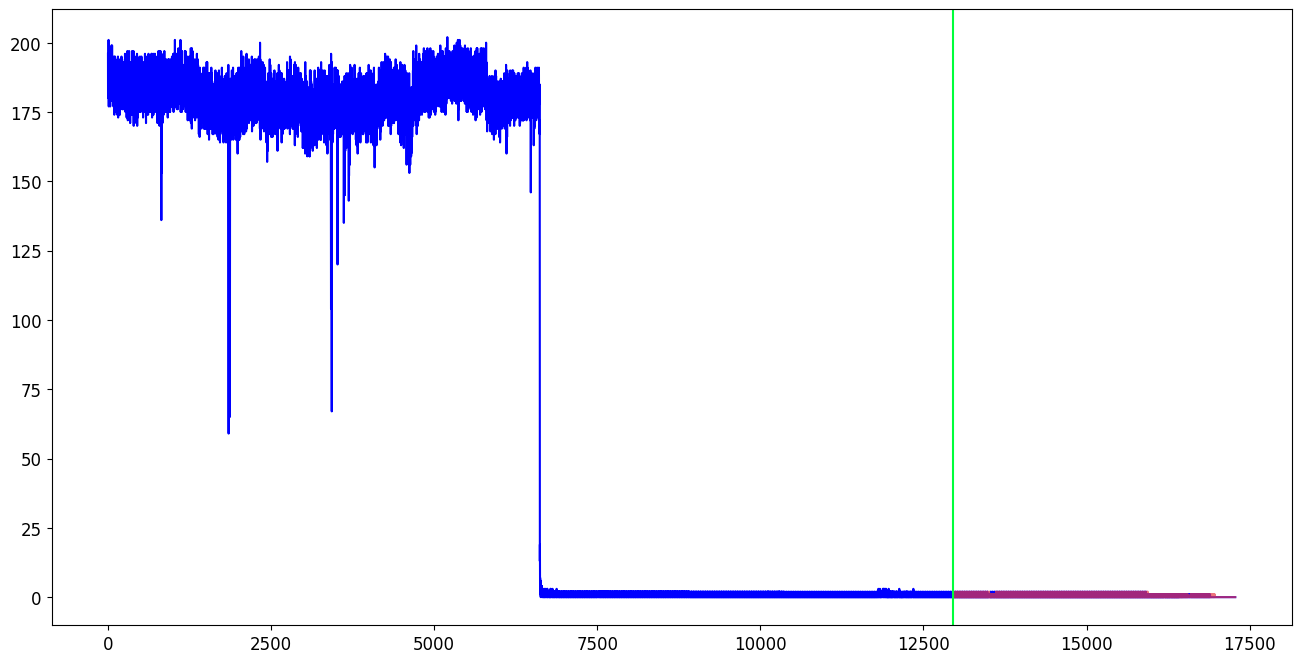

0c5d2d849802cf3d72bc4196fe11194b4be0e40187d136b863a021e733467732	Type:Appro-regular
CV:3.5120090043066408	PE:0.016426975520226525	Period:720.0	Period_Strength:0.11443777857959395	CV_WT:1.8247916933846389
Predict Windows:60mins	MAE:0.0	MSE:0.0	RMSE:0.0	sMAPE:0.0


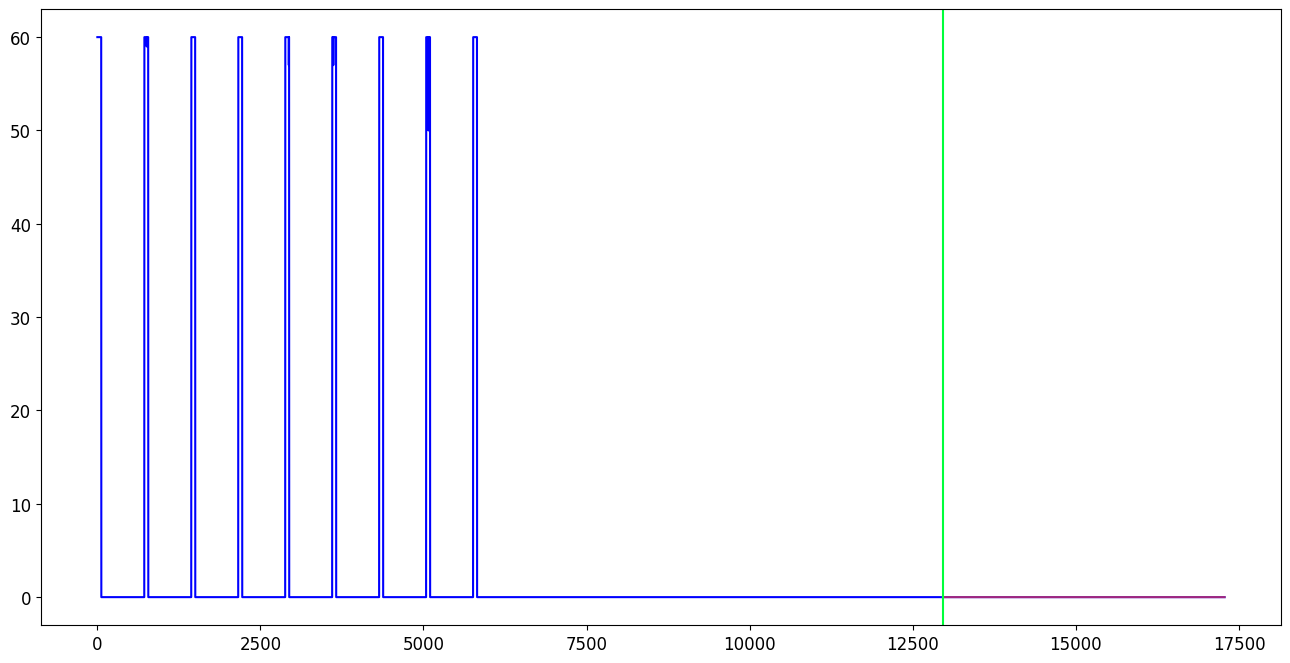

Predict Windows:30mins	MAE:0.0	MSE:0.0	RMSE:0.0	sMAPE:0.0


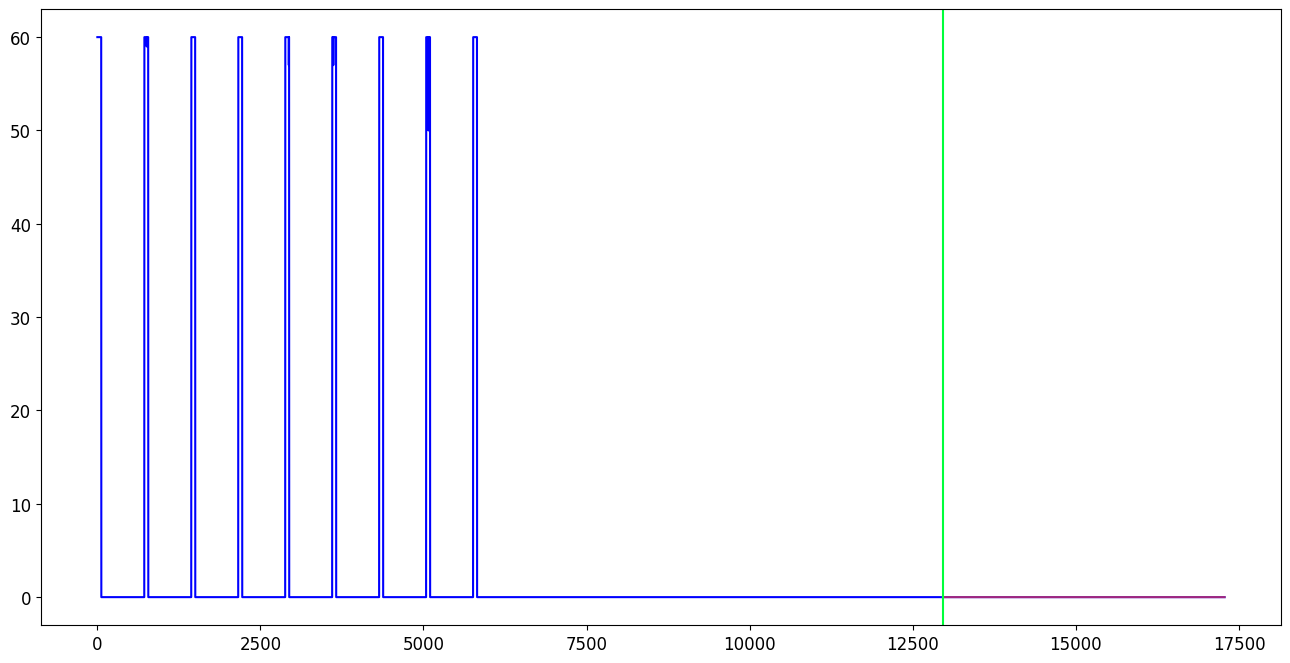

1b3bb5f765c2688f8fe609ff217de8ae852957a8ce629b35b0e79cd6194b9a0c	Type:Possible
CV:4.9409759302223	PE:0.43666090630798776	Period:60.0	Period_Strength:0.039764724563089514	CV_WT:14.123359204358103
Predict Windows:60mins	MAE:0.0	MSE:0.0	RMSE:0.0	sMAPE:0.0


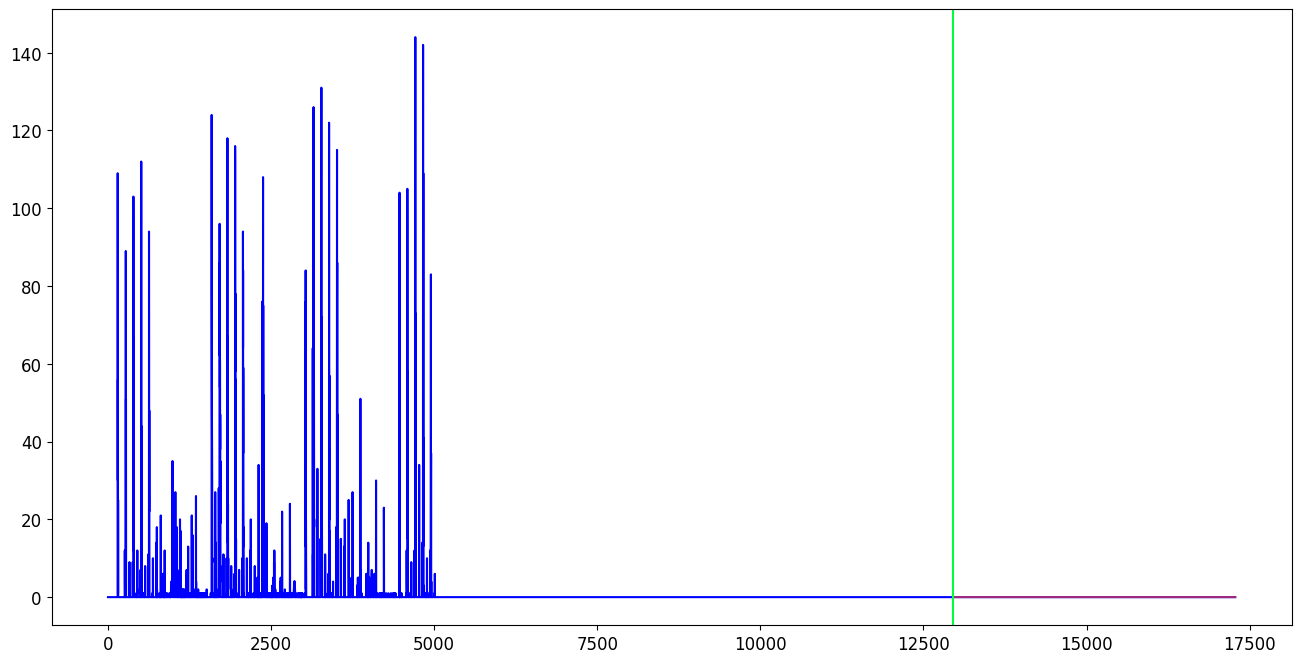

Predict Windows:30mins	MAE:0.0	MSE:0.0	RMSE:0.0	sMAPE:0.0


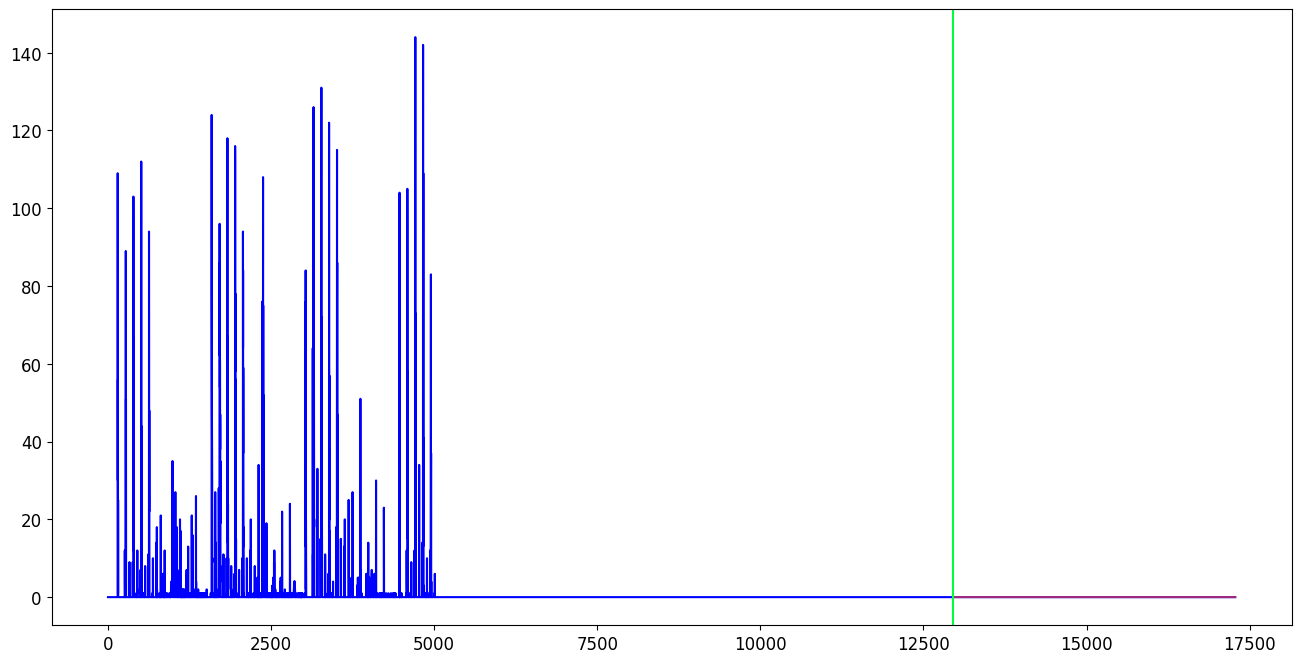

0b4a02def7fd092fd832c0c93bcedc4692657bc46856128102d0d9fc5135e4ea	Type:Successive
CV:3.228339815511372	PE:0.29817253550818357	Period:1440.0	Period_Strength:0.1012777841525472	CV_WT:4.499747713529086
Predict Windows:60mins	MAE:0.092	MSE:0.023	RMSE:0.152	sMAPE:0.805


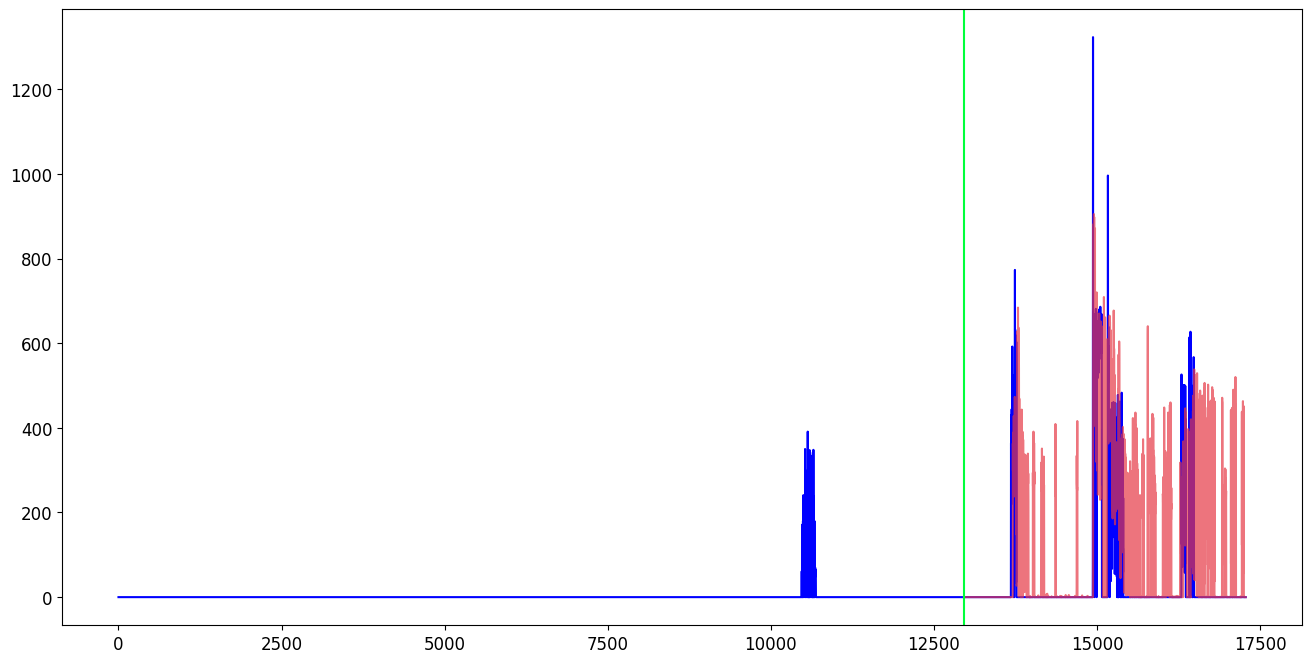

Predict Windows:30mins	MAE:0.072	MSE:0.018	RMSE:0.134	sMAPE:0.657


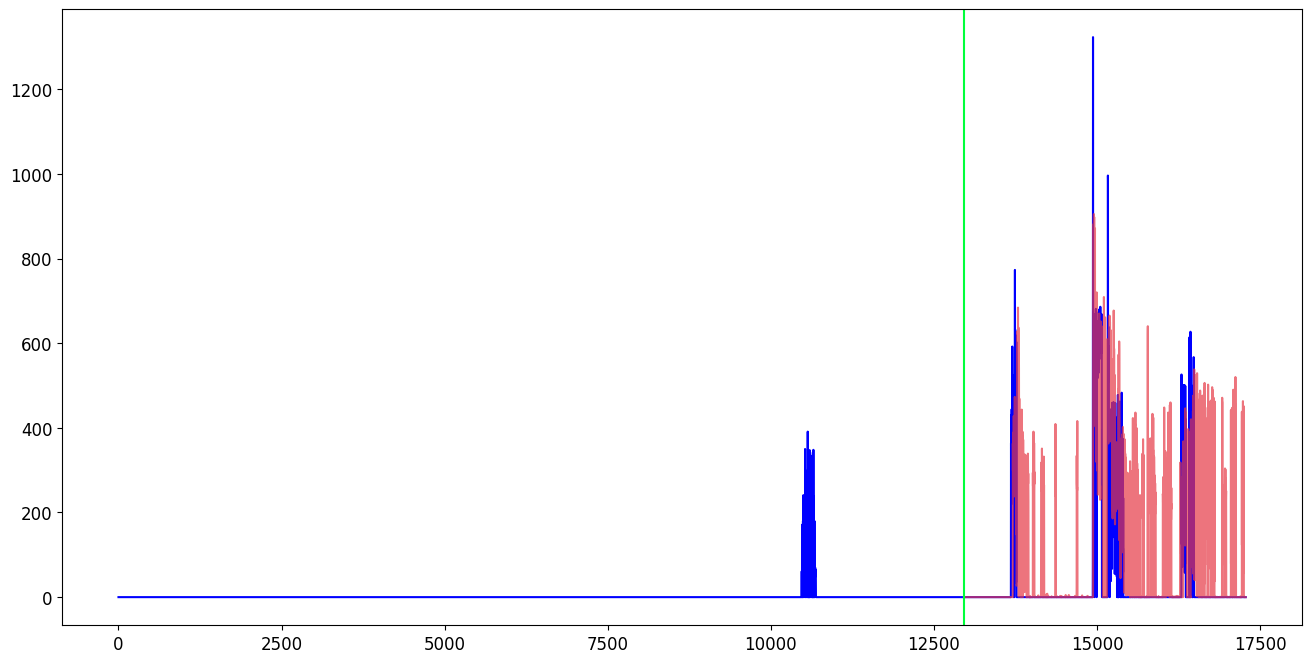

0b87437bfd30959c1324295a991fb10e5fb23ed7a0c5d388d31266bceeee0098	Type:Possible
CV:3.836893241173247	PE:0.33841373422006177	Period:1439.9999999999998	Period_Strength:0.0509572464057706	CV_WT:5.557672325515463
Predict Windows:60mins	MAE:0.054	MSE:0.008	RMSE:0.089	sMAPE:1.24


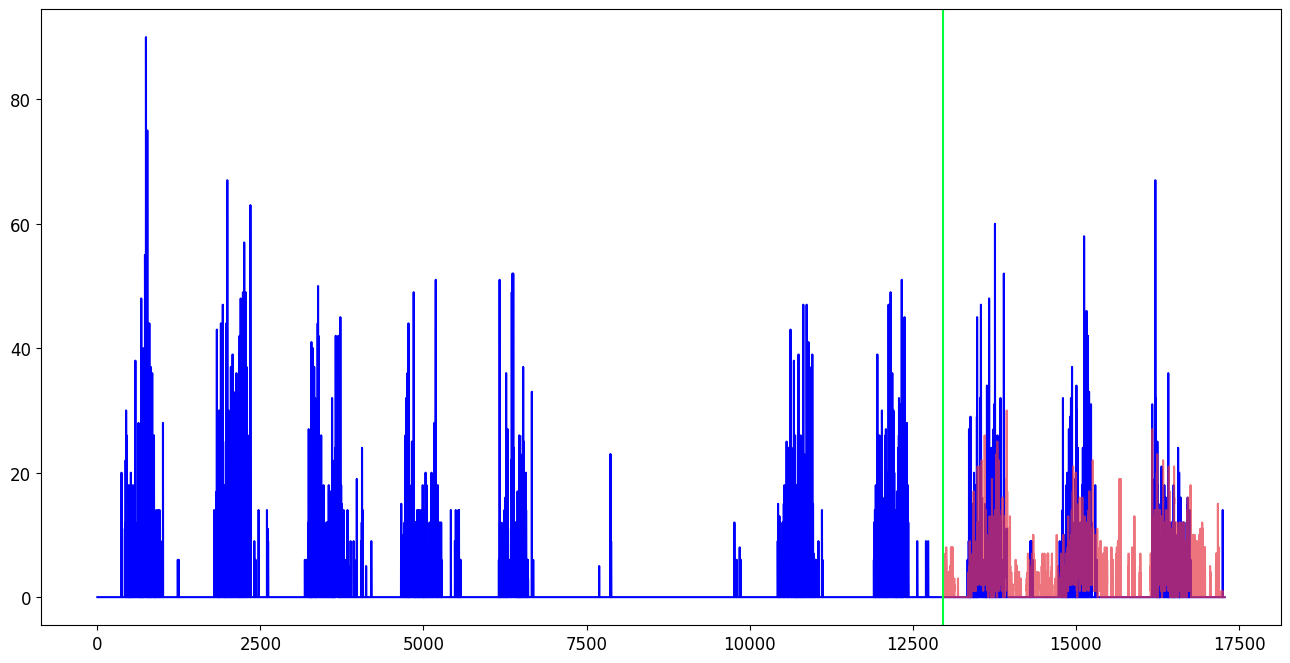

Predict Windows:30mins	MAE:0.047	MSE:0.007	RMSE:0.084	sMAPE:1.069


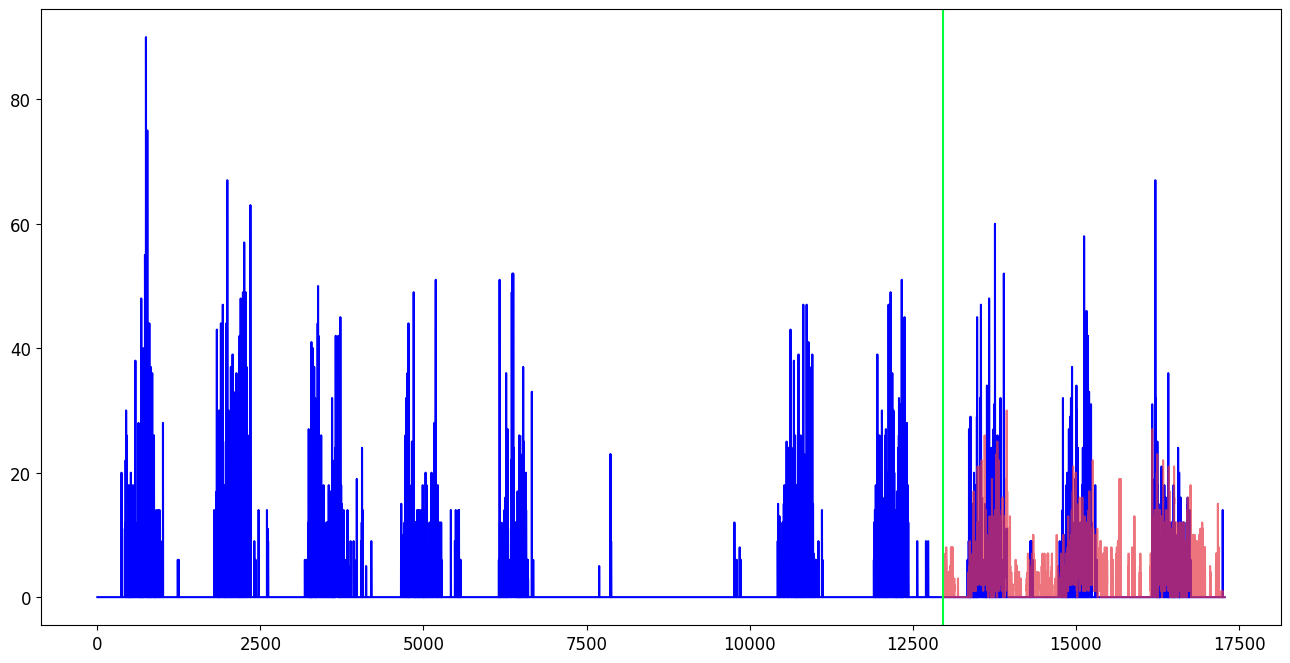

0ba17de49e52a61feb0387514cc43d3c4a6cd81c78f71f121d5b2763c9df07e4	Type:Possible
CV:4.679456095381076	PE:0.31878665678374335	Period:1439.9999999999998	Period_Strength:0.027160894958955573	CV_WT:7.38797681347
Predict Windows:60mins	MAE:0.038	MSE:0.006	RMSE:0.08	sMAPE:0.752


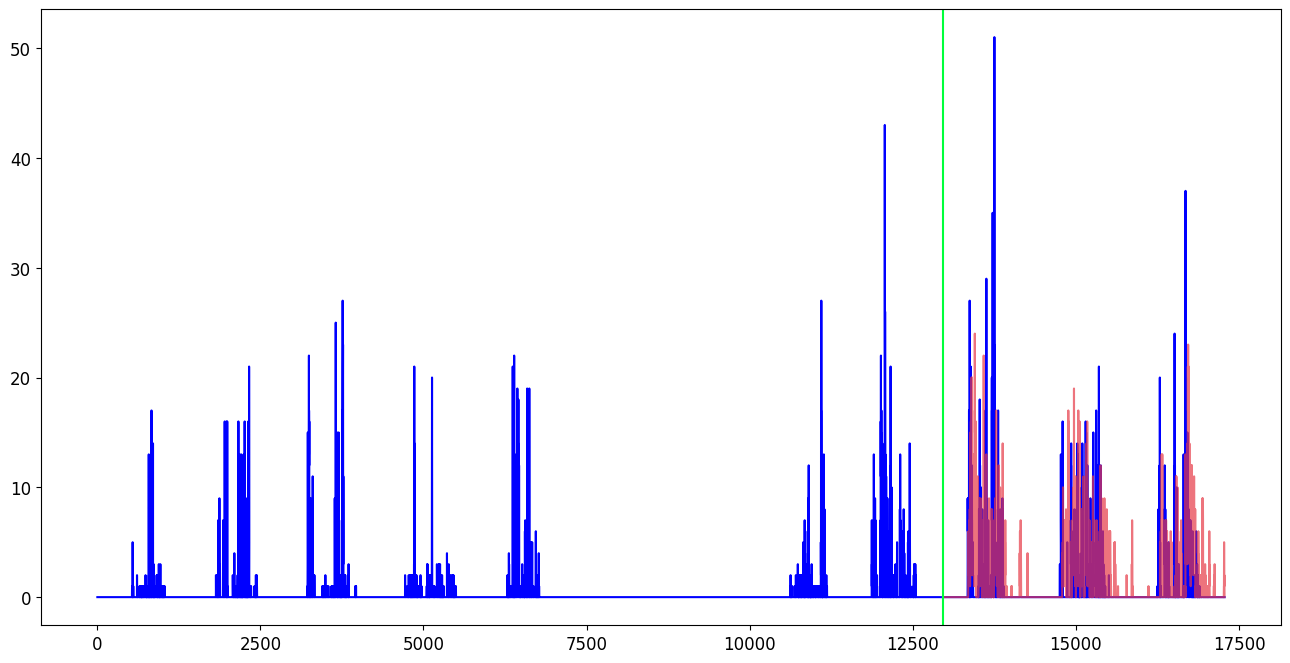

Predict Windows:30mins	MAE:0.035	MSE:0.006	RMSE:0.074	sMAPE:0.72


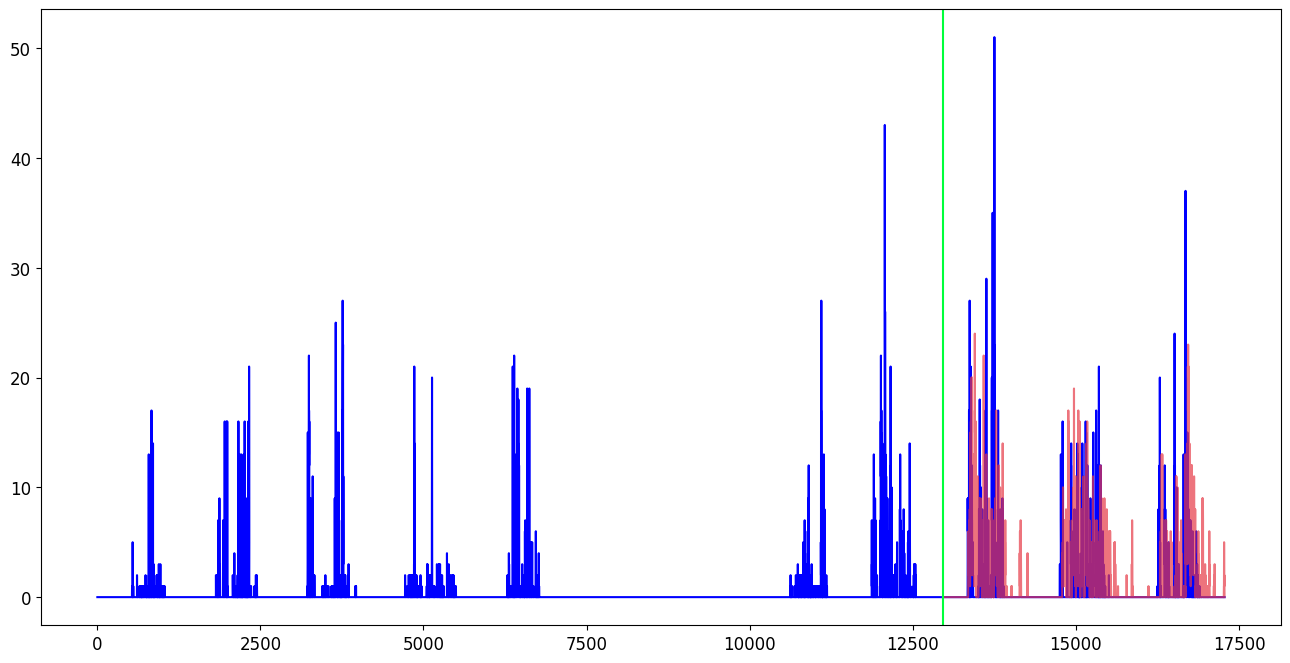

7ef3e326424ae81979f934174564ad7539e9241895fc5527fcd6e2b02f9ca376	Type:Appro-regular
CV:2.913813904362437	PE:0.5231909522533005	Period:1440.0	Period_Strength:0.24132372890216502	CV_WT:7.7506554713759135
Predict Windows:60mins	MAE:0.025	MSE:0.007	RMSE:0.083	sMAPE:0.174


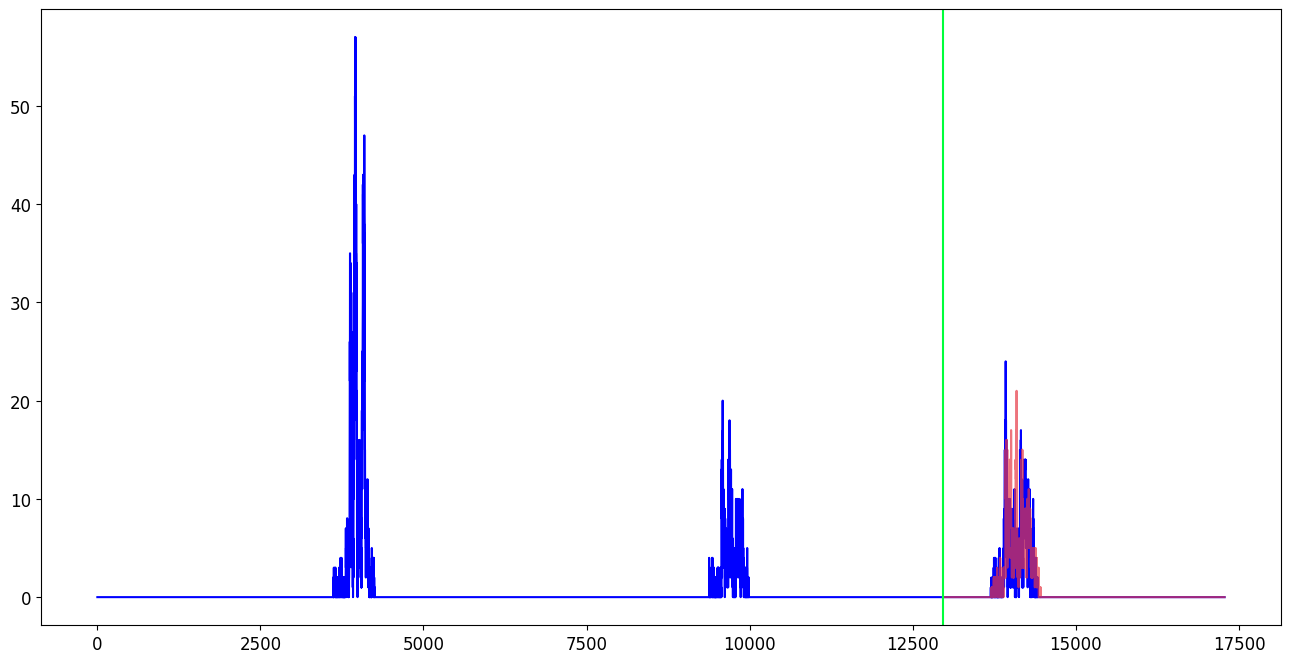

Predict Windows:30mins	MAE:0.023	MSE:0.007	RMSE:0.081	sMAPE:0.153


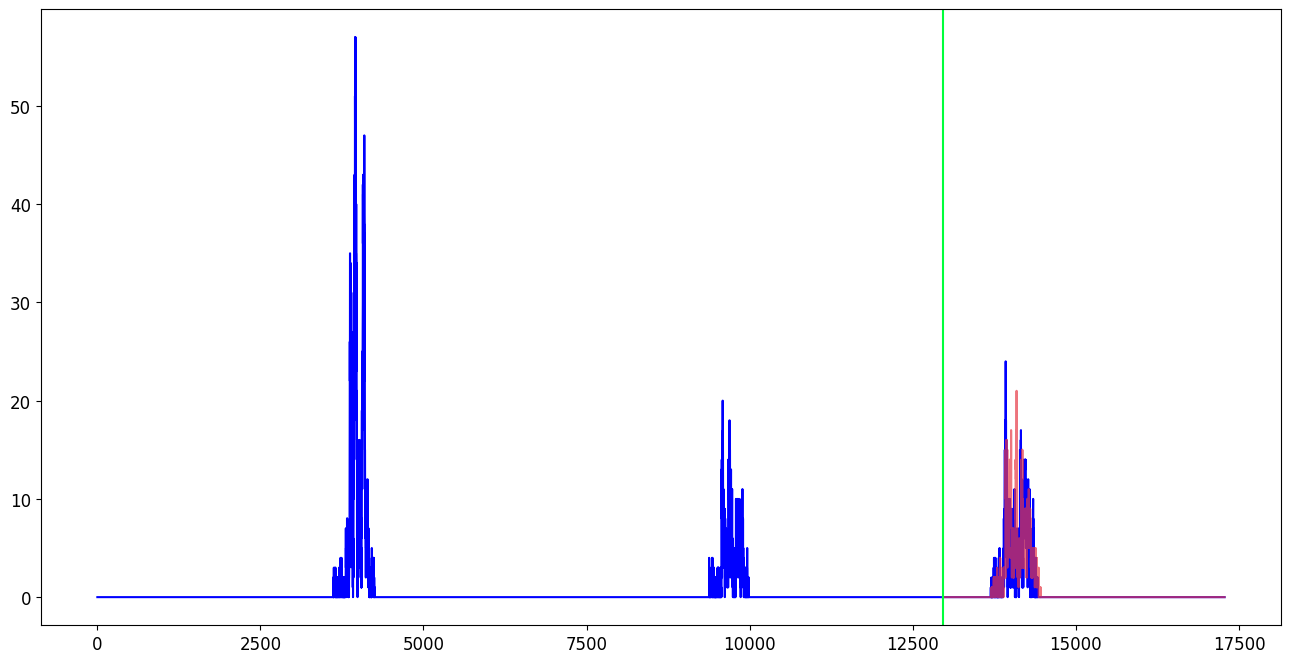

0b35e6779bcc7a254461d1d35090fef2bf14305d303957da1cbc62e03ea9d1f1	Type:Possible
CV:3.621477841566516	PE:0.2434480226485552	Period:1439.9999999999998	Period_Strength:0.02613781110883982	CV_WT:1.3217484296824349
Predict Windows:60mins	MAE:0.202	MSE:0.07	RMSE:0.265	sMAPE:1.537


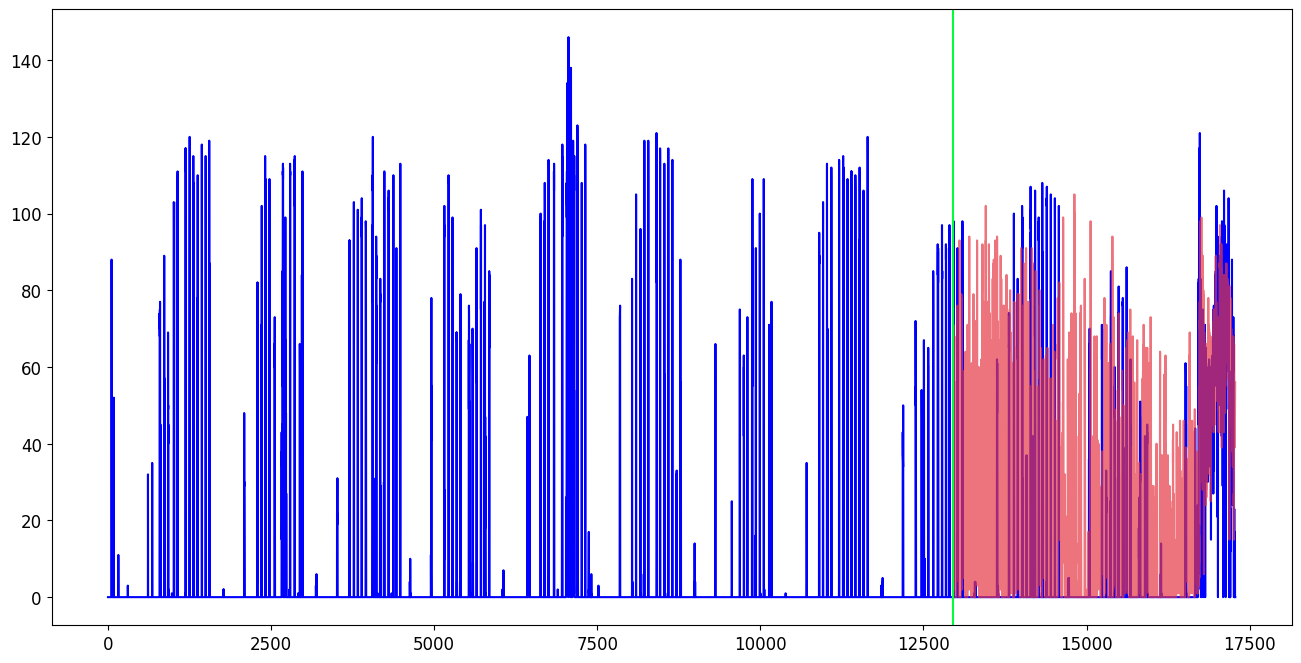

Predict Windows:30mins	MAE:0.183	MSE:0.068	RMSE:0.261	sMAPE:1.349


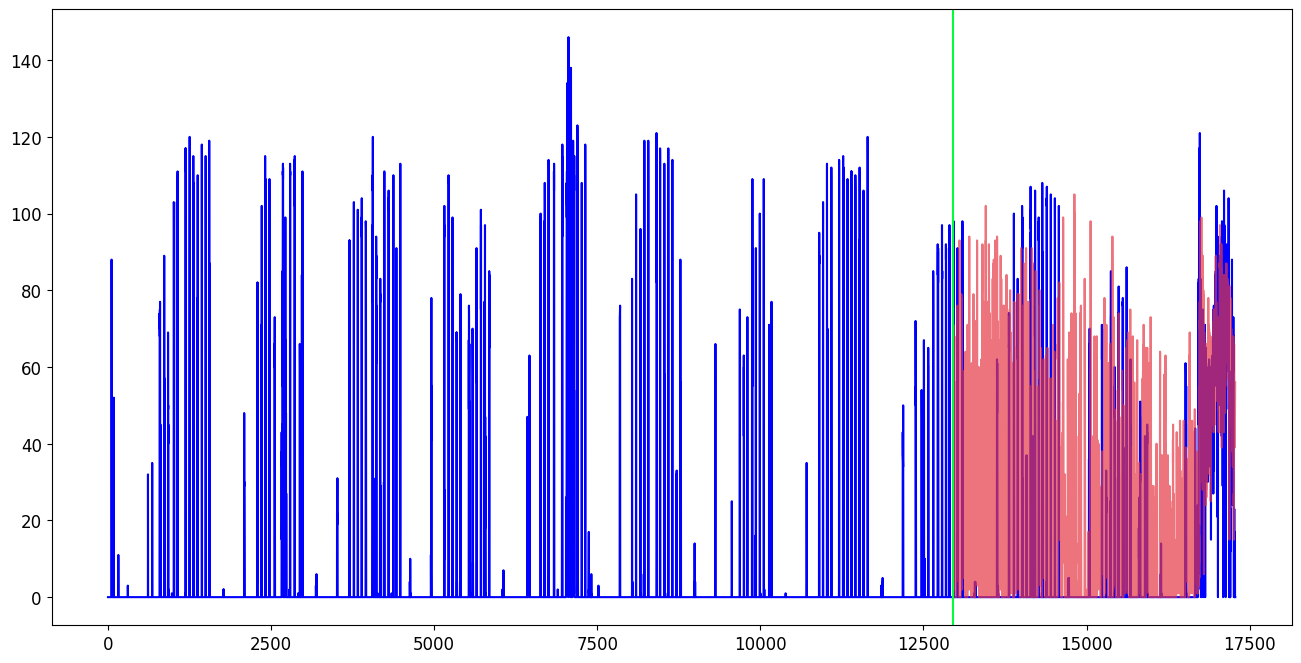

0b54e8dcc3be570e3327fd371e351b71f11fefa1566d0488e3e00aeecb83260b	Type:Possible
CV:4.325733388331129	PE:0.21560158107792068	Period:60.0	Period_Strength:0.0694133207657846	CV_WT:0.97648792837961
Predict Windows:60mins	MAE:0.036	MSE:0.013	RMSE:0.115	sMAPE:0.183


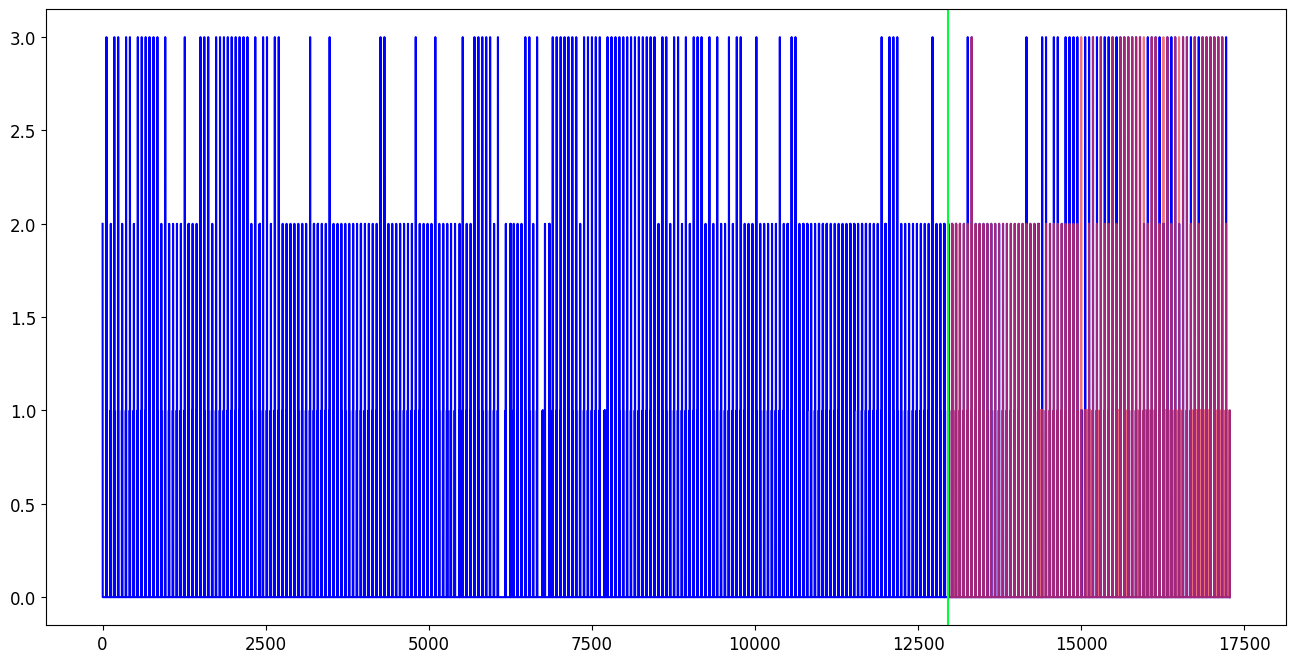

Predict Windows:30mins	MAE:0.024	MSE:0.009	RMSE:0.095	sMAPE:0.113


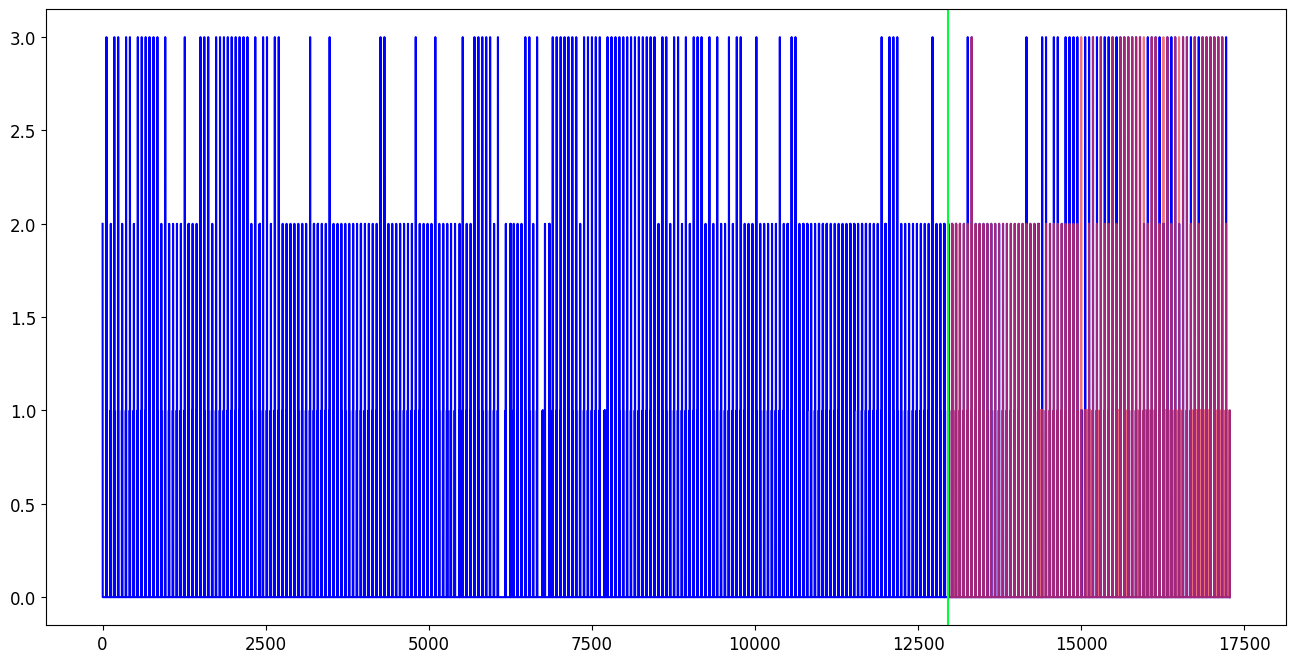

0bb0a628699ef20450f3cdd35c9b43a973fe84c722f7210ca0dd9dd857befa89	Type:Possible
CV:4.76286507920168	PE:0.22524962769674448	Period:1439.9999999999998	Period_Strength:0.006294218176466284	CV_WT:1.926358208432655
Predict Windows:60mins	MAE:0.095	MSE:0.026	RMSE:0.16	sMAPE:1.398


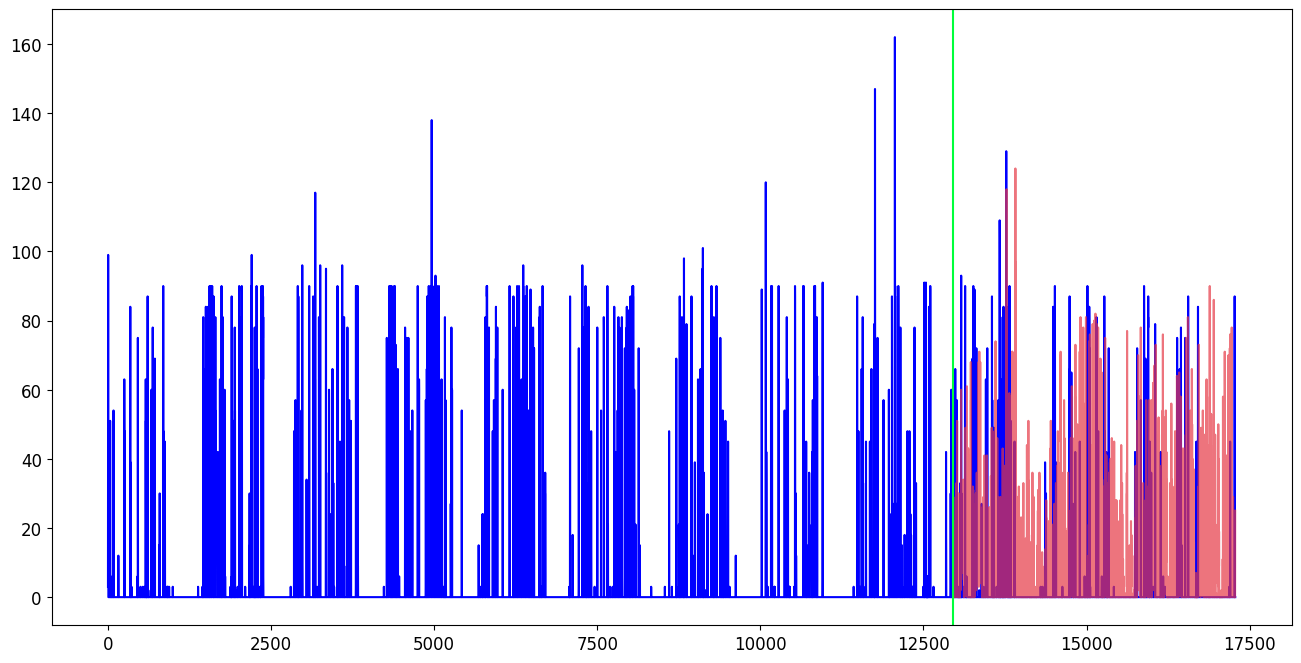

Predict Windows:30mins	MAE:0.088	MSE:0.025	RMSE:0.157	sMAPE:1.329


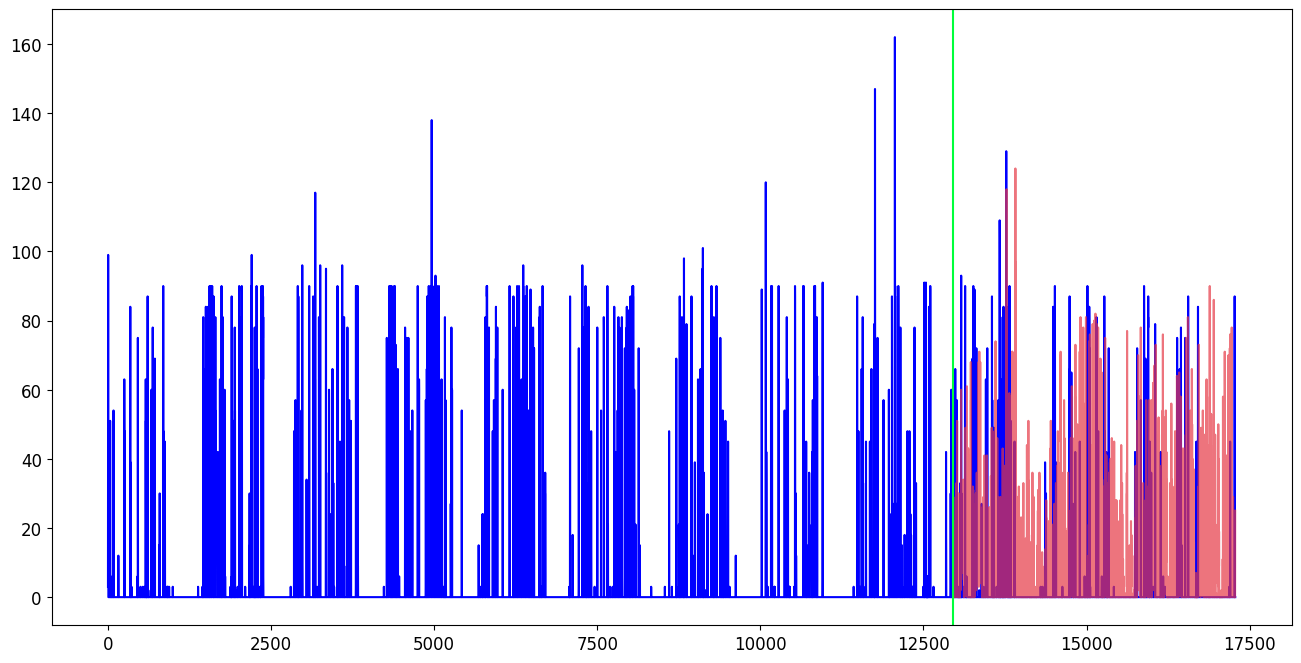

0cdb1be0c51ad64fbbb29a79054cc97add9bf65d6dac077e2aee9a4e083e5dbe	Type:Possible
CV:3.752912620114792	PE:0.18098439887088716	Period:359.99999999999994	Period_Strength:0.09019375790394973	CV_WT:0.3852453316136855
Predict Windows:60mins	MAE:0.089	MSE:0.05	RMSE:0.223	sMAPE:0.677


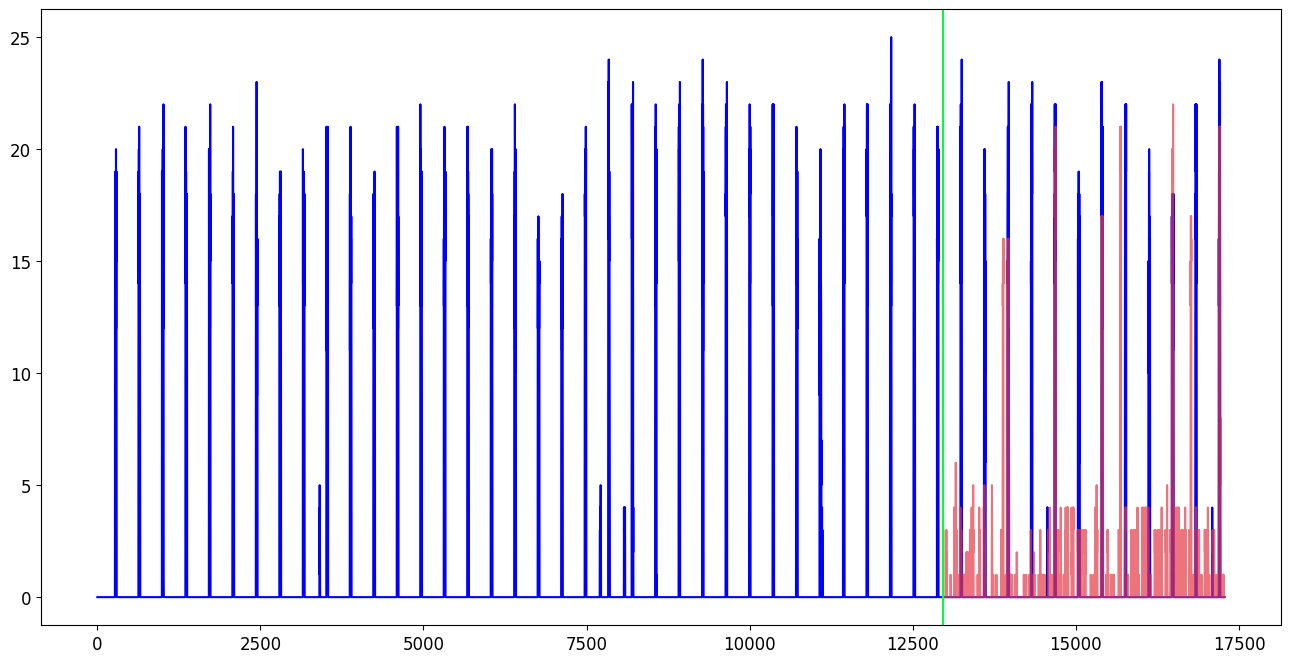

Predict Windows:30mins	MAE:0.05	MSE:0.023	RMSE:0.15	sMAPE:0.423


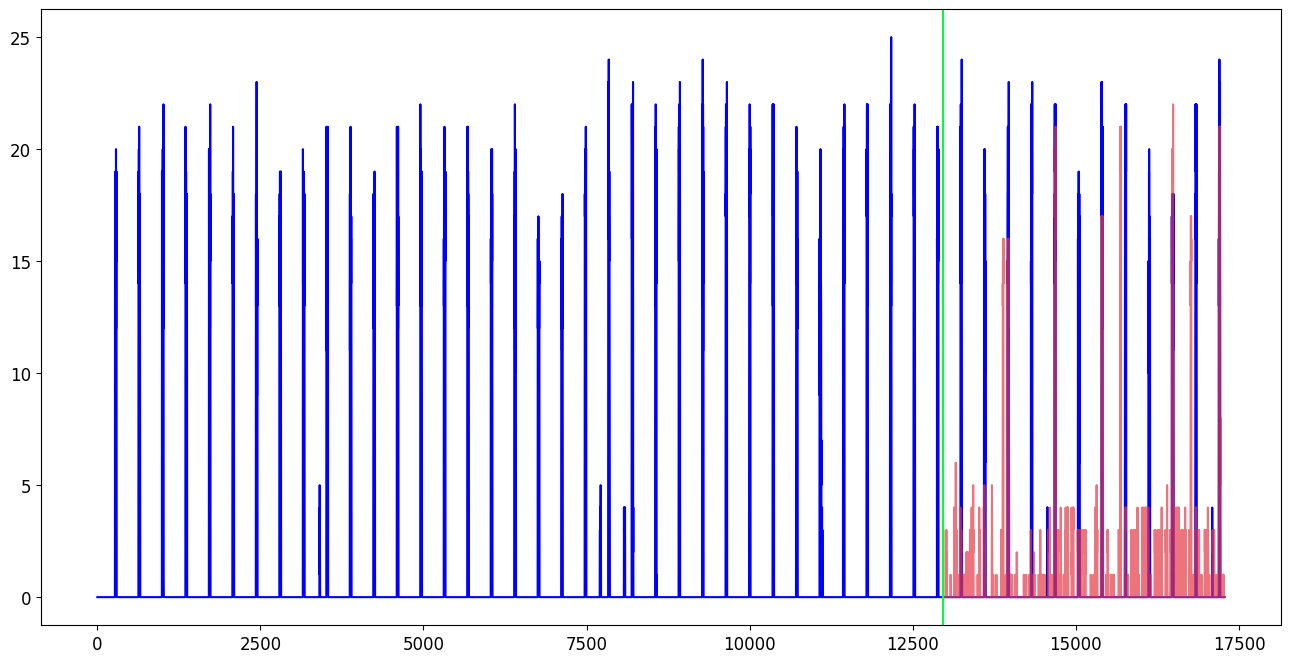

0e7d3f107c7d81d8ed6269cc6e5332d701c87bd4b17ad5d0e788672db664c446	Type:Appro-regular
CV:0.11893228992314366	PE:0.1393073430963415	Period:1439.9999999999998	Period_Strength:0.02531944448285678	CV_WT:3.607741149473866
Predict Windows:60mins	MAE:0.024	MSE:0.003	RMSE:0.056	sMAPE:0.062


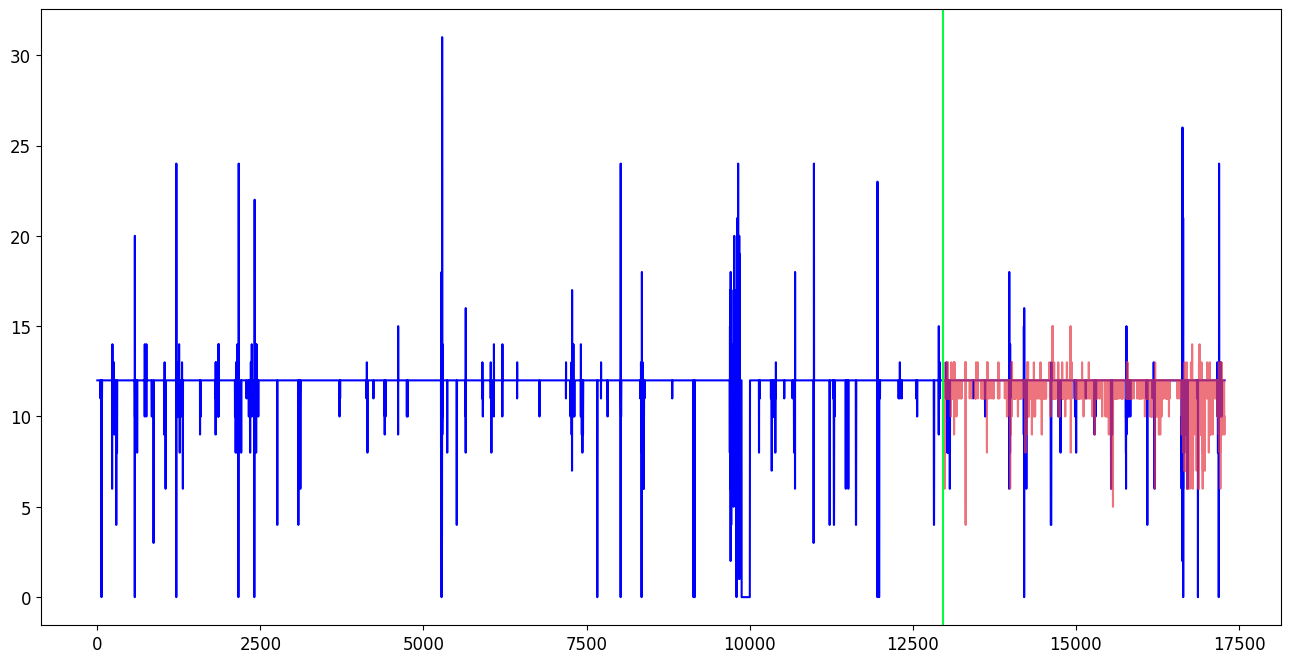

Predict Windows:30mins	MAE:0.02	MSE:0.003	RMSE:0.052	sMAPE:0.052


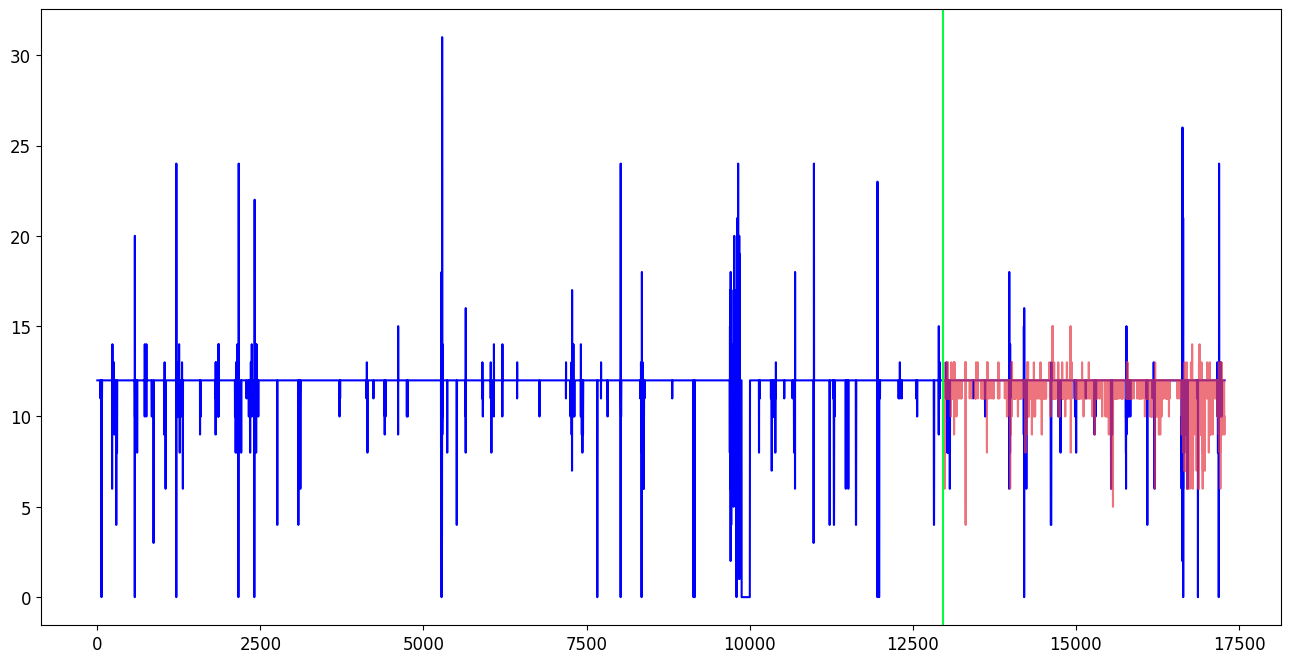

0e84de2b676f4e1bb80cbf72c5062e11bf3f0331860f0460b72ebcdc52543087	Type:Possible
CV:3.191342874732339	PE:0.6414355736333529	Period:10080.0	Period_Strength:0.0800352596076107	CV_WT:6.508953805714686
Predict Windows:60mins	MAE:0.041	MSE:0.019	RMSE:0.138	sMAPE:0.917


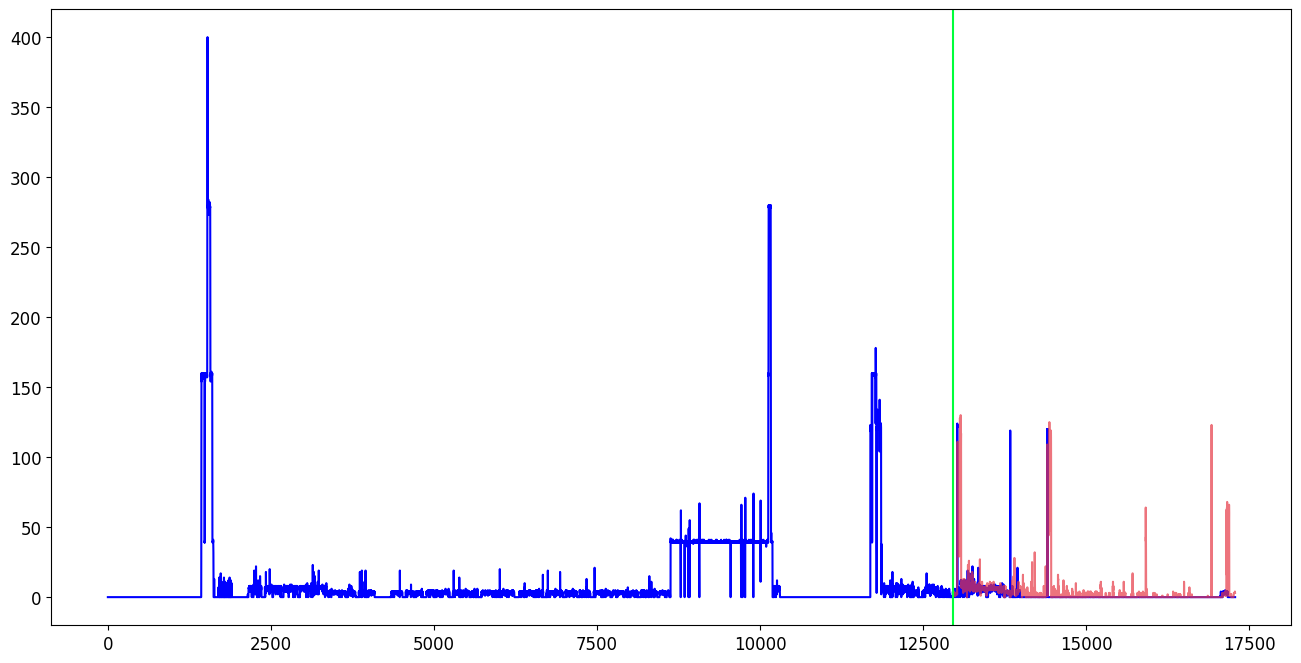

Predict Windows:30mins	MAE:0.036	MSE:0.018	RMSE:0.134	sMAPE:0.733


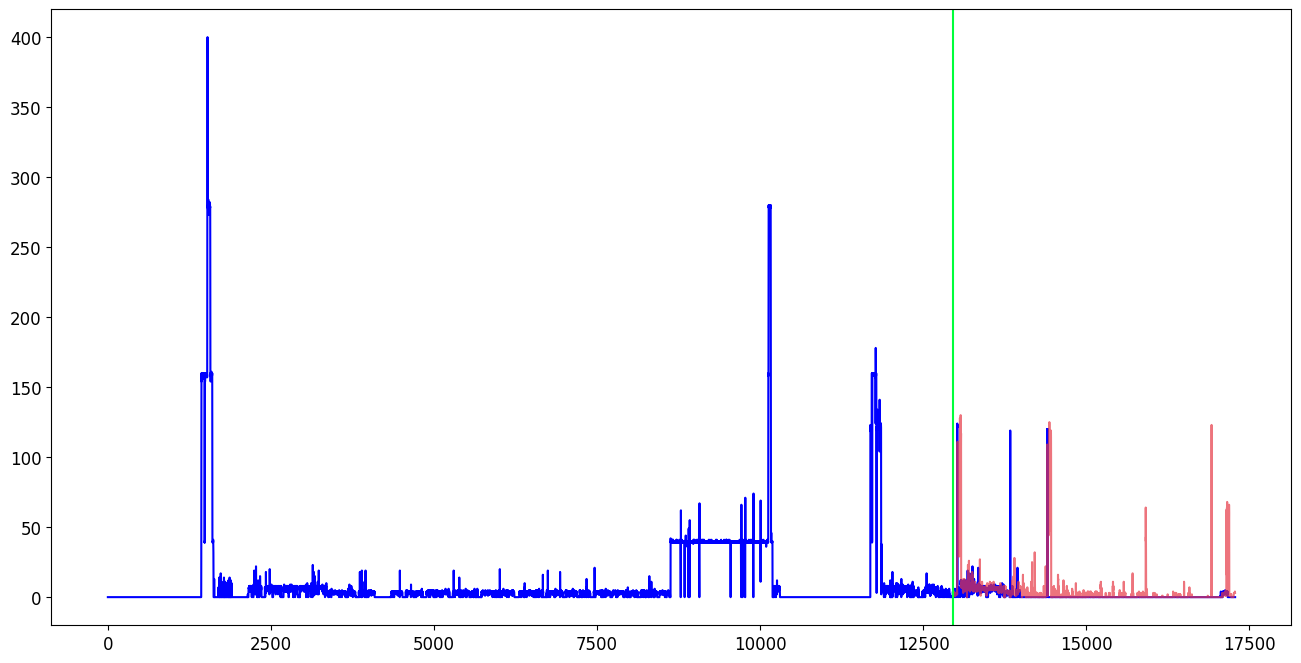

0f83920d4c438fdf3e814aa24a23fda73d5efd0604af7fea7d85d125d4083609	Type:Successive
CV:0.2706546474665334	PE:0.1333648486813794	Period:5040.0	Period_Strength:0.17437682841649874	CV_WT:1.88259994532293
Predict Windows:60mins	MAE:0.1	MSE:0.034	RMSE:0.184	sMAPE:0.122


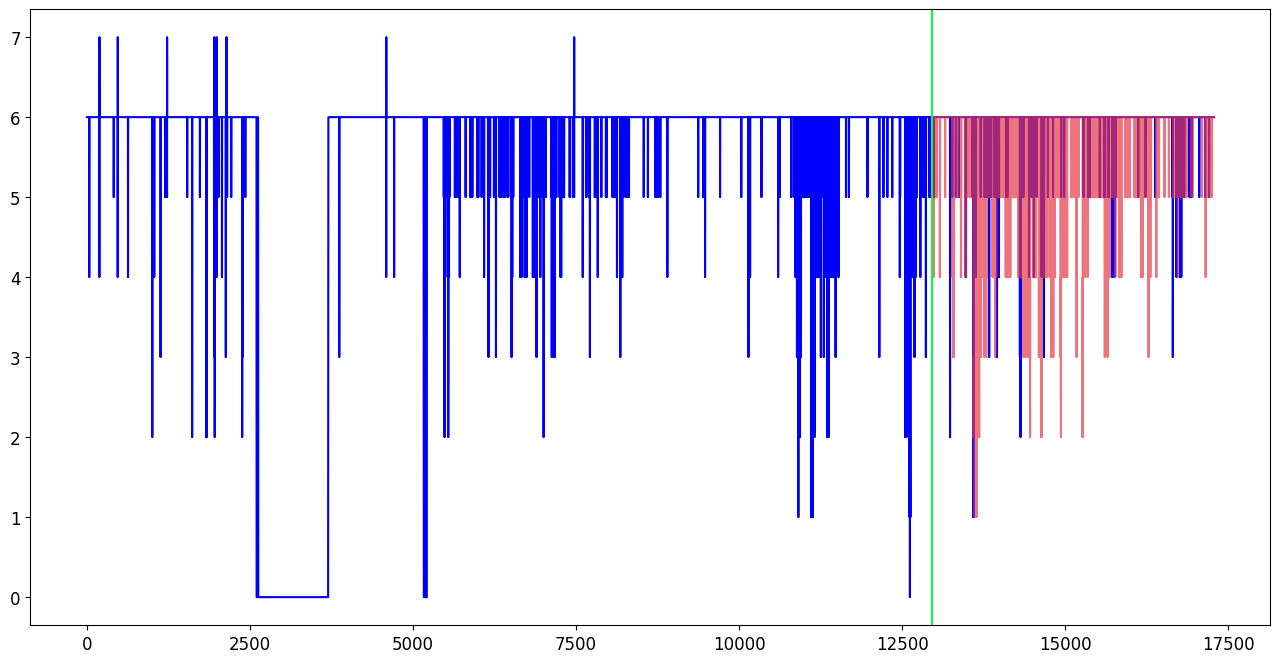

Predict Windows:30mins	MAE:0.066	MSE:0.023	RMSE:0.152	sMAPE:0.082


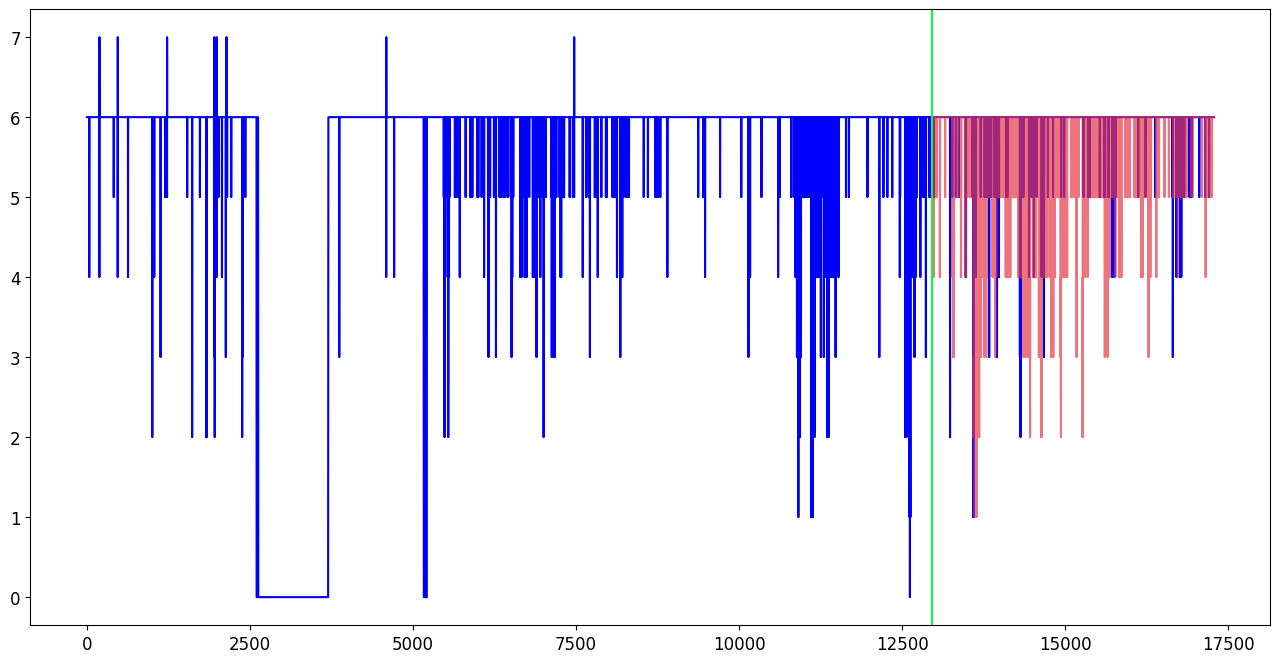

0faf768b12d32974470c17014501d5aa47af963c20cc2ebe4a0f5d9318d211b8	Type:Possible
CV:0.5336547973503516	PE:0.8633114168939395	Period:10080.0	Period_Strength:0.28161855189972523	CV_WT:3.584985875096207
Predict Windows:60mins	MAE:0.029	MSE:0.004	RMSE:0.066	sMAPE:0.06


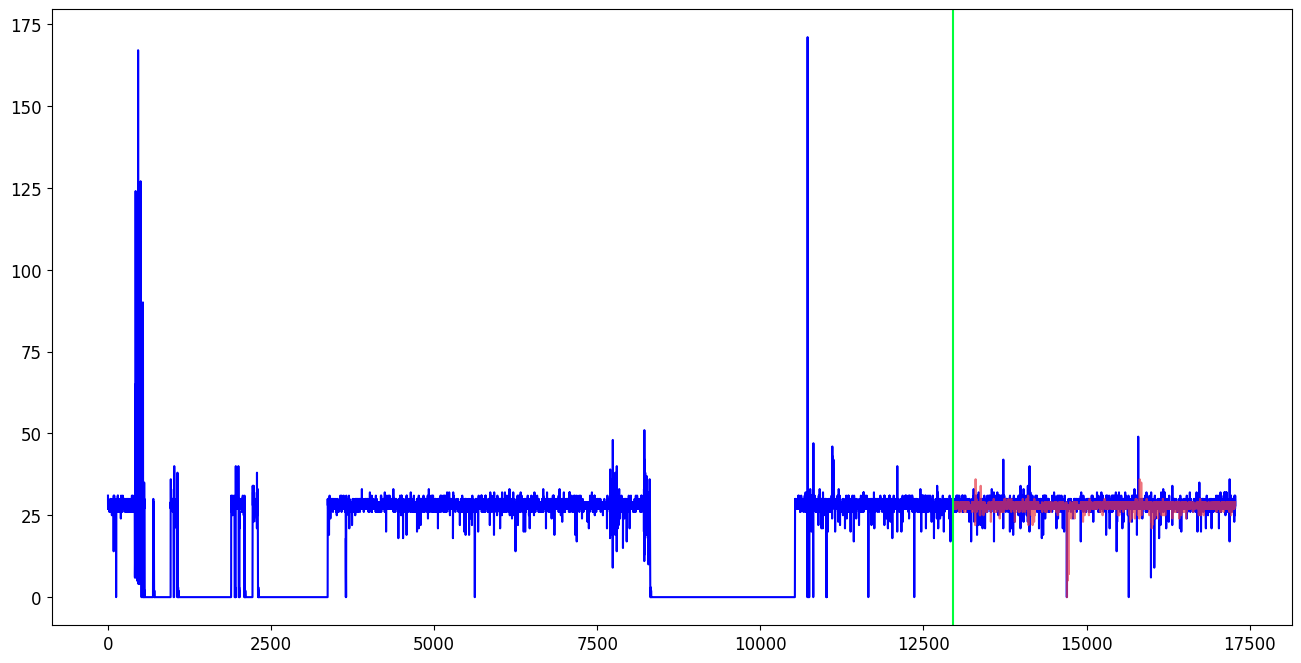

Predict Windows:30mins	MAE:0.027	MSE:0.003	RMSE:0.057	sMAPE:0.054


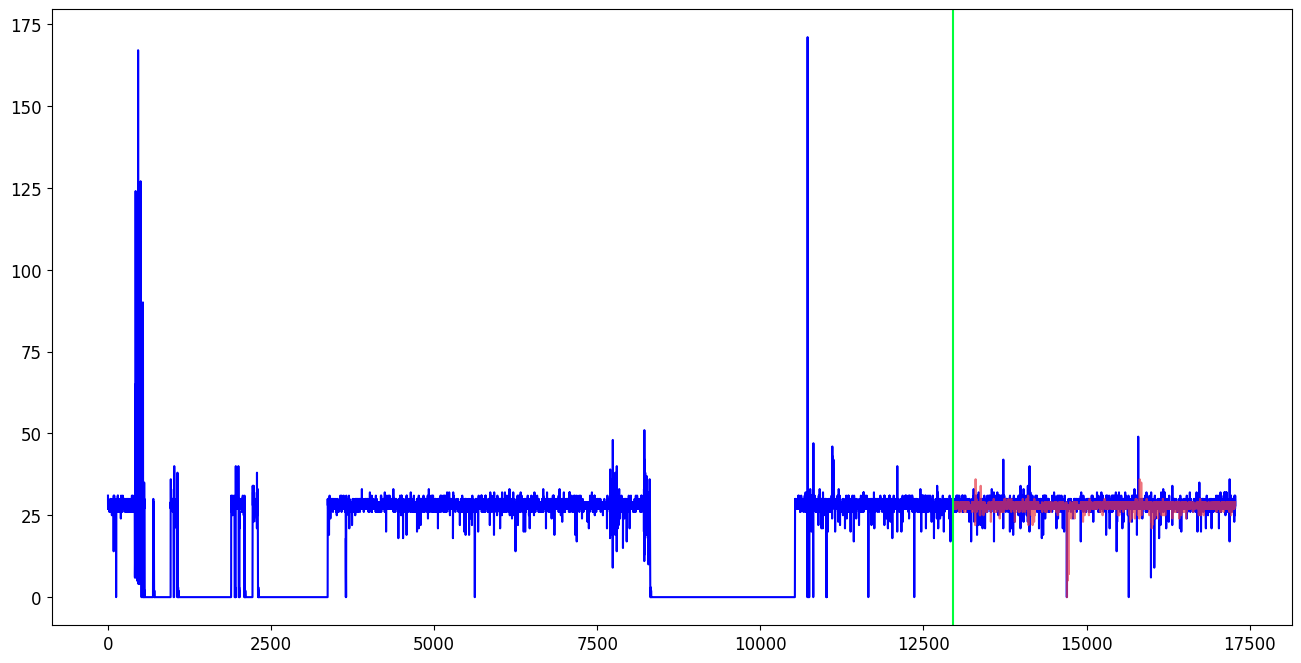

3ea752d4544b3df15bac8057b9270c531823583a0ed4682134e46fb17b04cfb6	Type:Dense
CV:2.6384520726574148	PE:0.875484615909415	Period:5040.0	Period_Strength:0.2596543718690459	CV_WT:0.9840885614681143
Predict Windows:60mins	MAE:0.039	MSE:0.003	RMSE:0.053	sMAPE:1.149


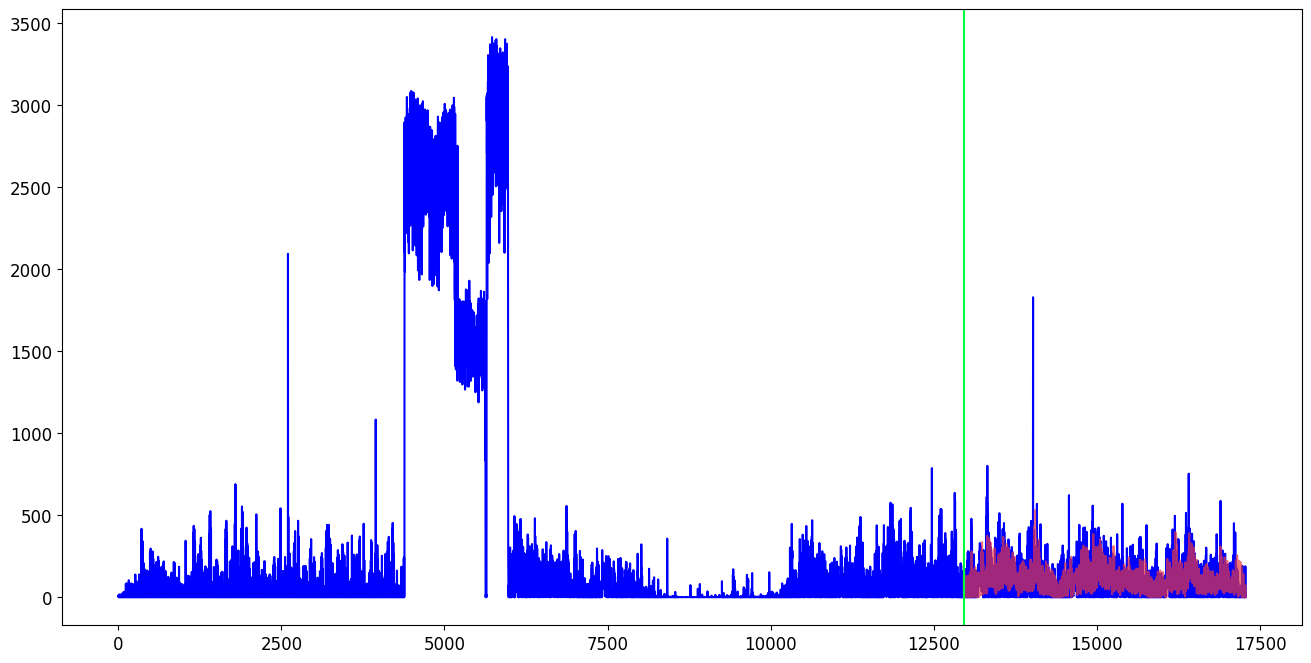

Predict Windows:30mins	MAE:0.037	MSE:0.003	RMSE:0.051	sMAPE:1.138


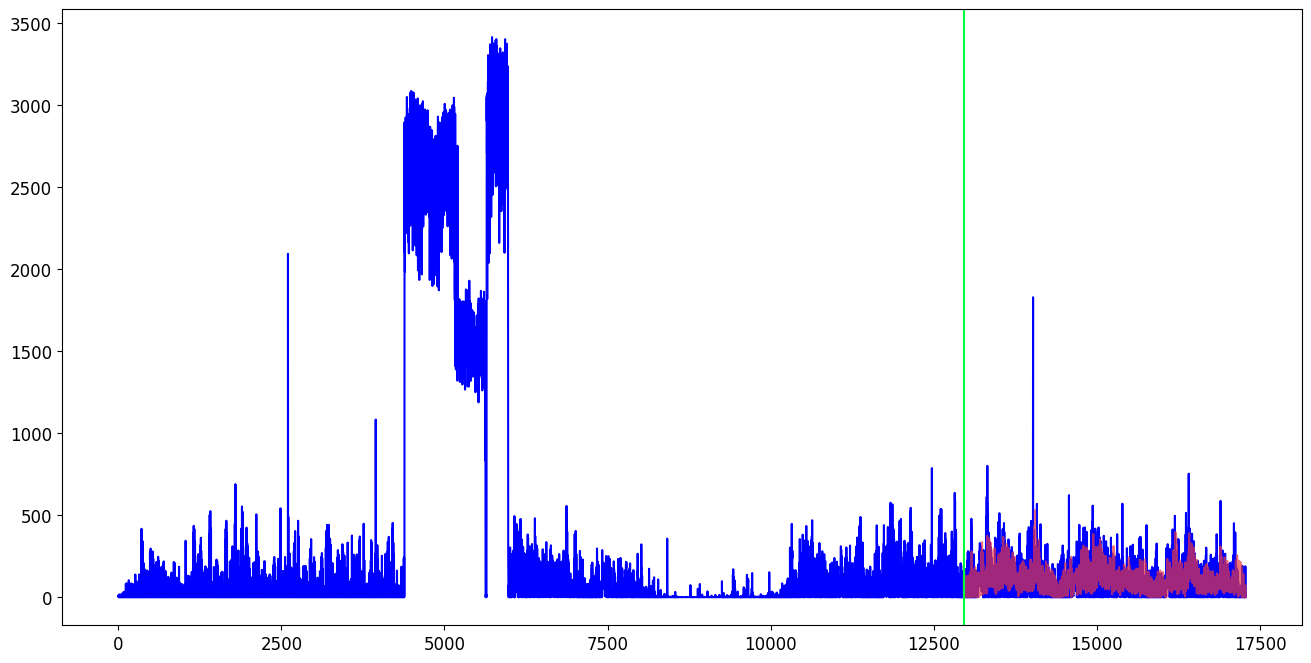

5e98666f0af3fee4a98e670ab893ddf57046816b30775e3decd77a098d317e98	Type:Appro-regular
CV:0.3840324674817961	PE:0.9778119442960967	Period:5040.0	Period_Strength:0.34911958049185077	CV_WT:0.4263717277625373
Predict Windows:60mins	MAE:0.053	MSE:0.014	RMSE:0.119	sMAPE:0.141


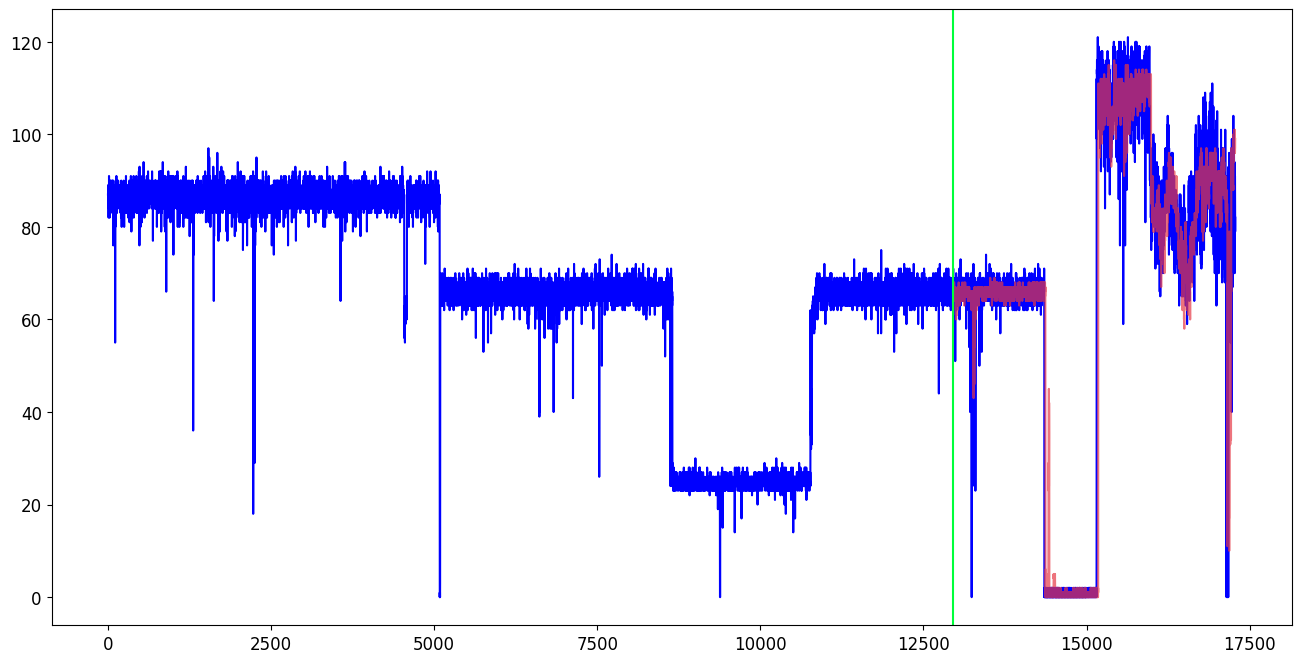

Predict Windows:30mins	MAE:0.044	MSE:0.011	RMSE:0.103	sMAPE:0.129


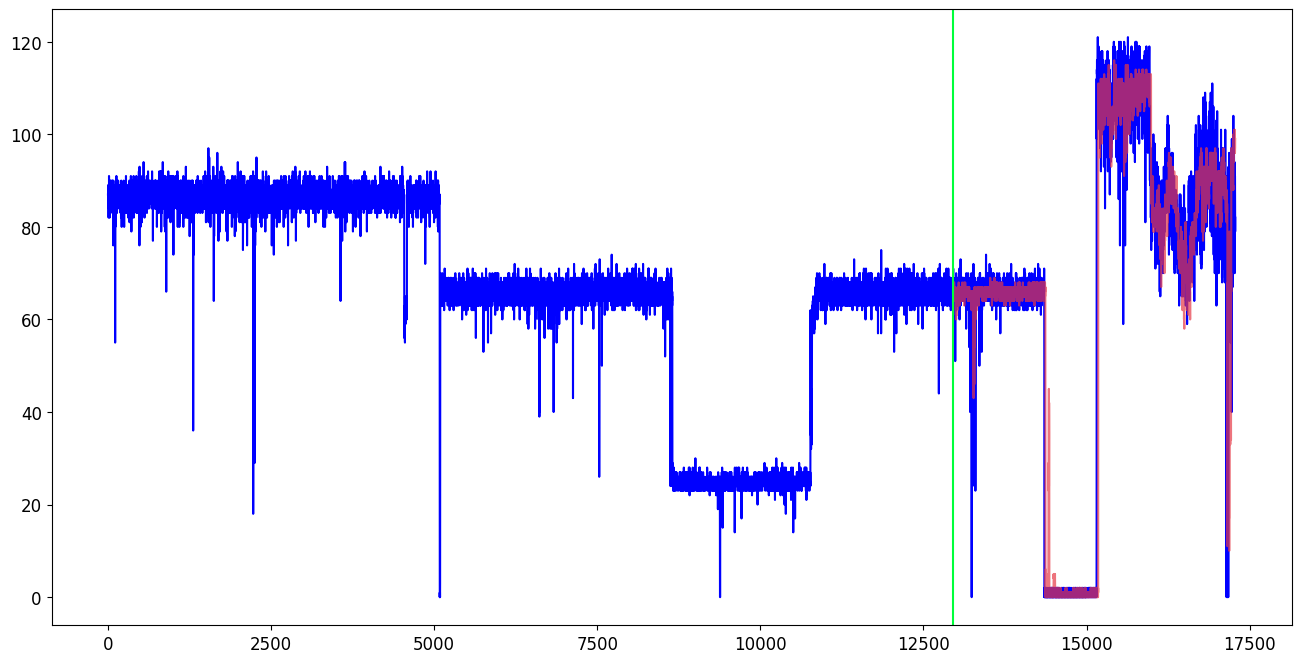

5f8204c622e5f08709ed85aefdcc02f4f9ac8991a747aa4b2d61d9f113123ade	Type:Possible
CV:16.67244451216866	PE:0.25865987774602656	Period:1439.9999999999998	Period_Strength:0.004623836151986322	CV_WT:4.581878837075295
Predict Windows:60mins	MAE:0.016	MSE:0.008	RMSE:0.087	sMAPE:0.719


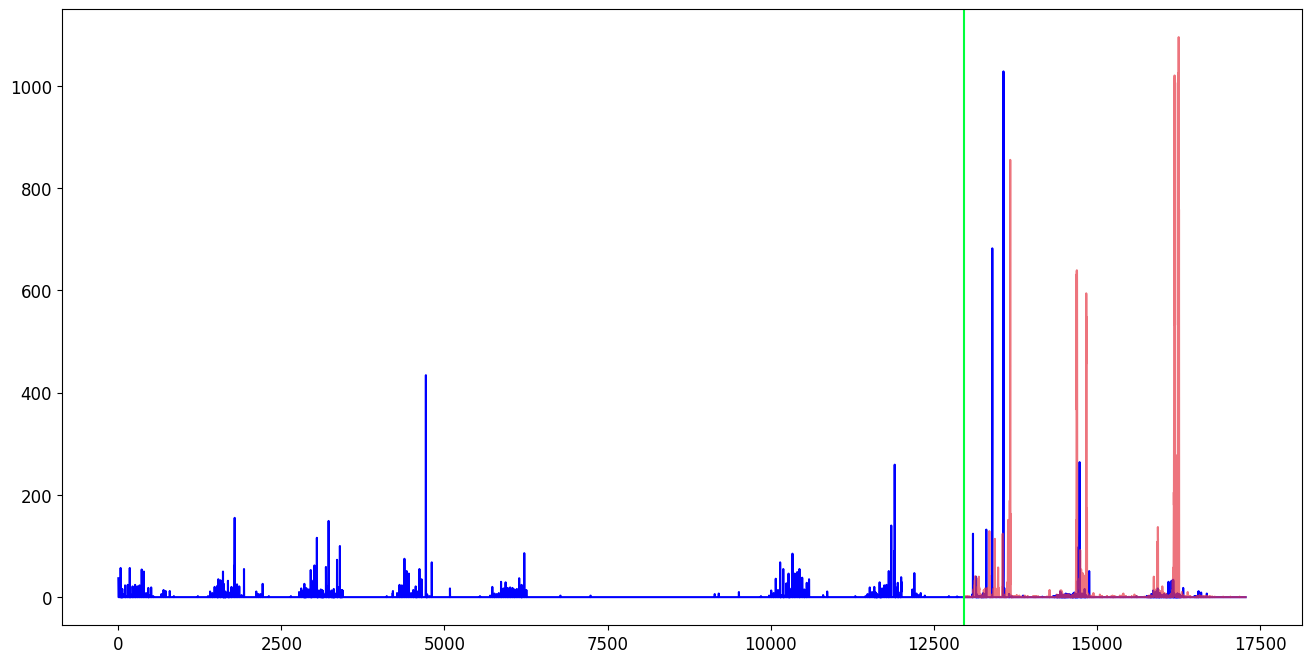

Predict Windows:30mins	MAE:0.013	MSE:0.006	RMSE:0.077	sMAPE:0.705


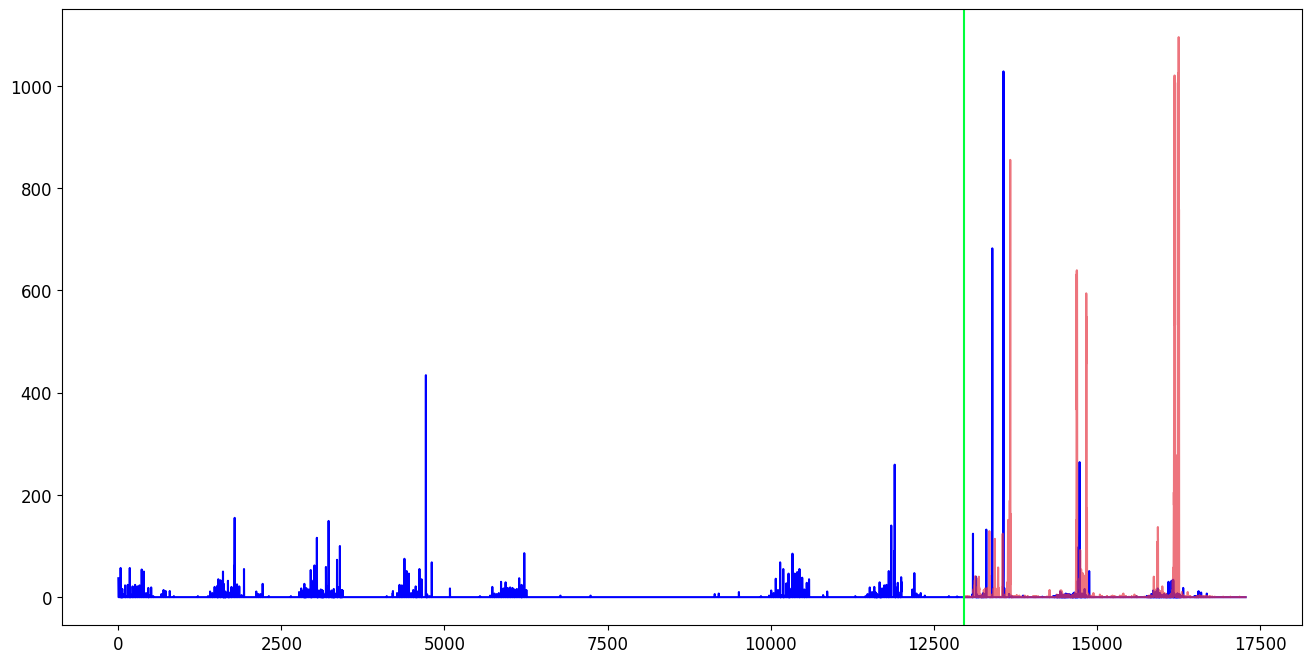

6ebf7f0531f610032fafaec9da2b0e701217aa2cff14a1c4cbf81c788e8bbbbb	Type:Appro-regular
CV:1.5651648442861699	PE:0.9628232727755465	Period:1439.9999999999998	Period_Strength:0.1026388405213373	CV_WT:0.9846619691826574
Predict Windows:60mins	MAE:0.02	MSE:0.002	RMSE:0.041	sMAPE:0.766


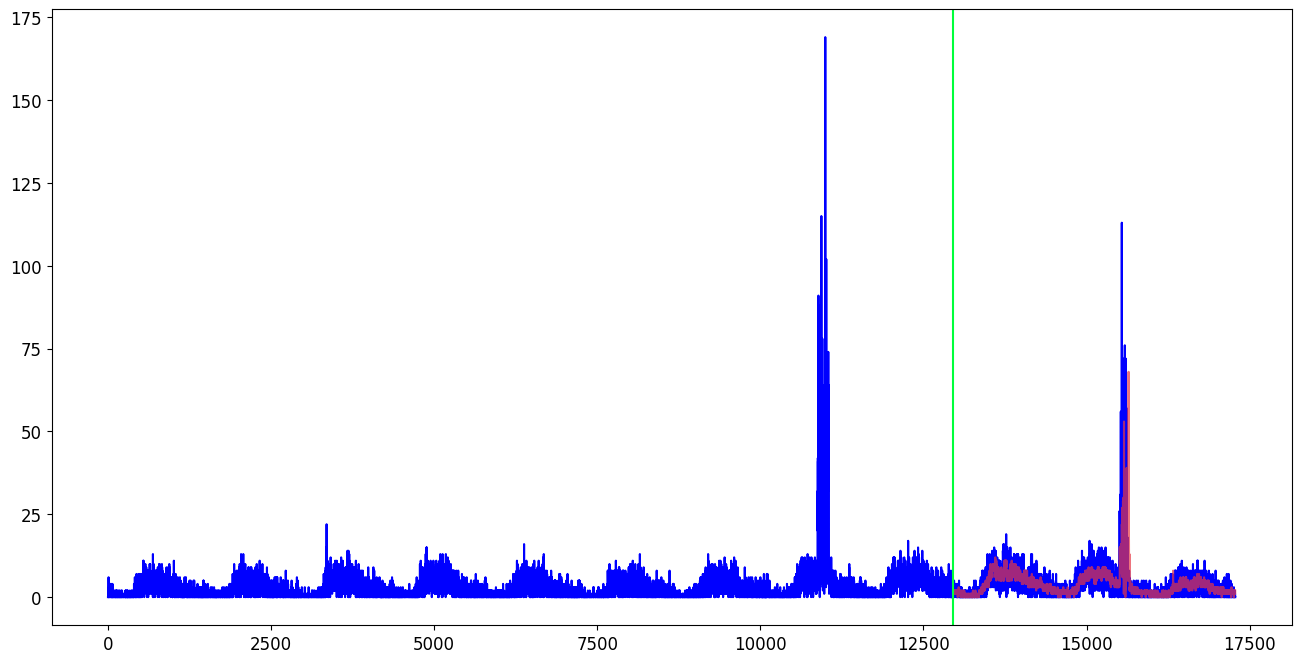

Predict Windows:30mins	MAE:0.019	MSE:0.001	RMSE:0.038	sMAPE:0.751


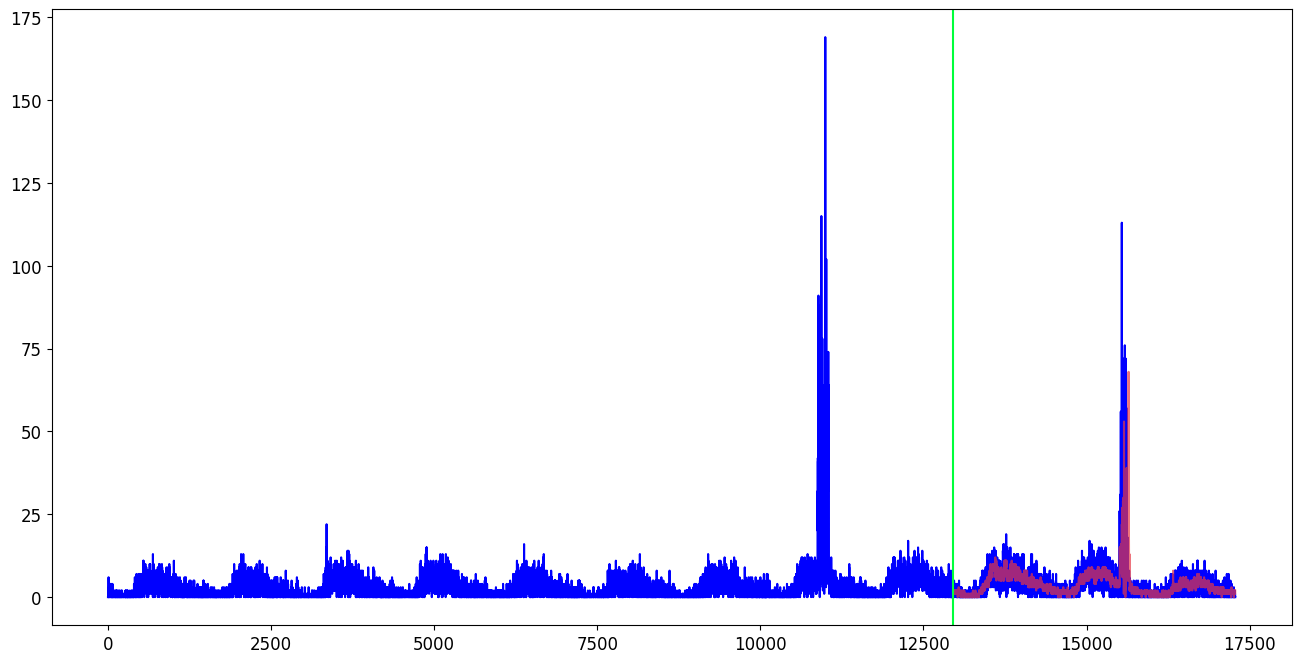

6f082405f22de6a4565902fa05f721b42223311af93dedcce96f907654fb45c9	Type:Successive
CV:1.1212662094930208	PE:0.3897480832673883	Period:1439.9999999999998	Period_Strength:0.3193275527941494	CV_WT:1.9819149893617403
Predict Windows:60mins	MAE:0.067	MSE:0.011	RMSE:0.105	sMAPE:0.157


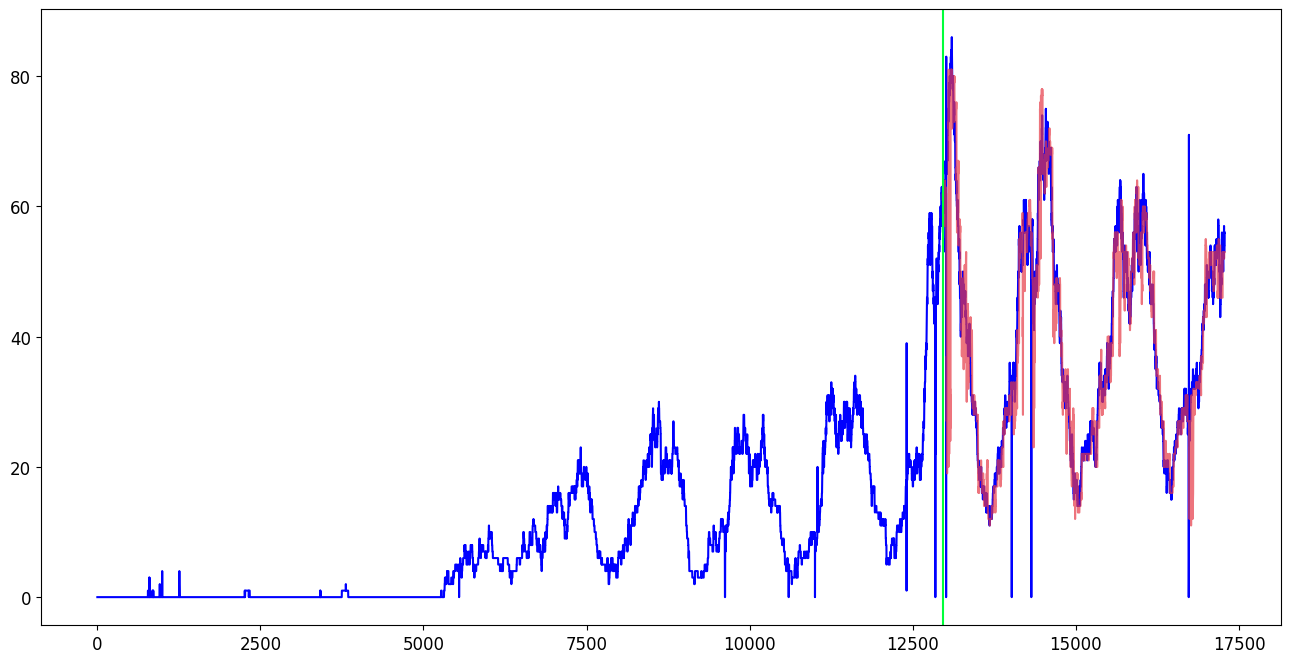

Predict Windows:30mins	MAE:0.046	MSE:0.007	RMSE:0.085	sMAPE:0.106


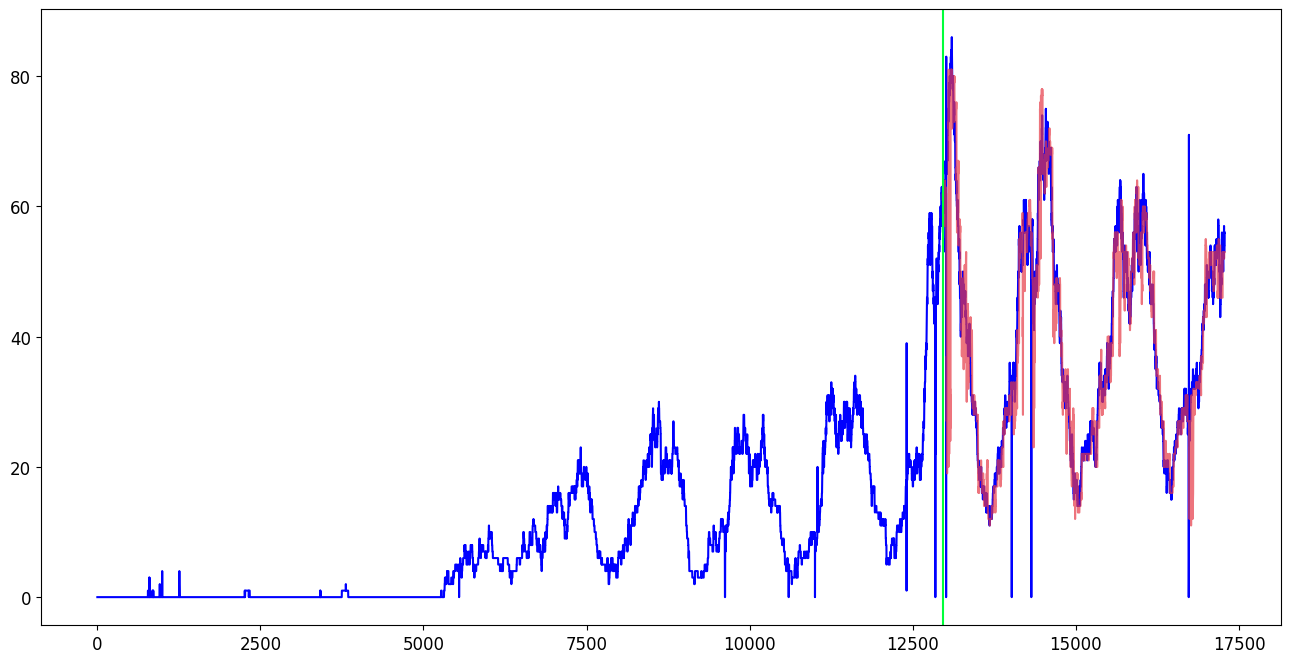

07dd21ddcfb3cffecb5eeb04de71d3e6c4d67bfc27ff1ba4f2df96a543546166	Type:Warm
CV:0.5710147988109748	PE:0.9970012873902158	Period:10080.0	Period_Strength:0.3040372582365073	CV_WT:0.2727272727272727
Predict Windows:60mins	MAE:0.081	MSE:0.011	RMSE:0.105	sMAPE:0.171


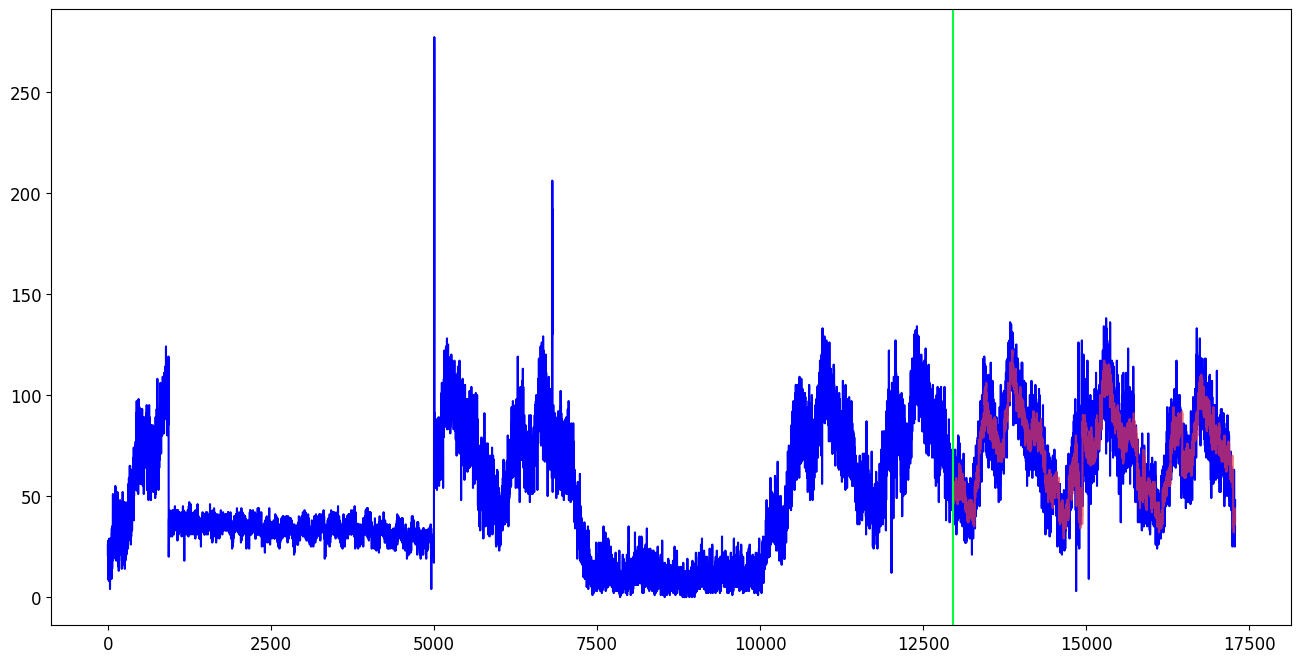

Predict Windows:30mins	MAE:0.072	MSE:0.009	RMSE:0.093	sMAPE:0.151


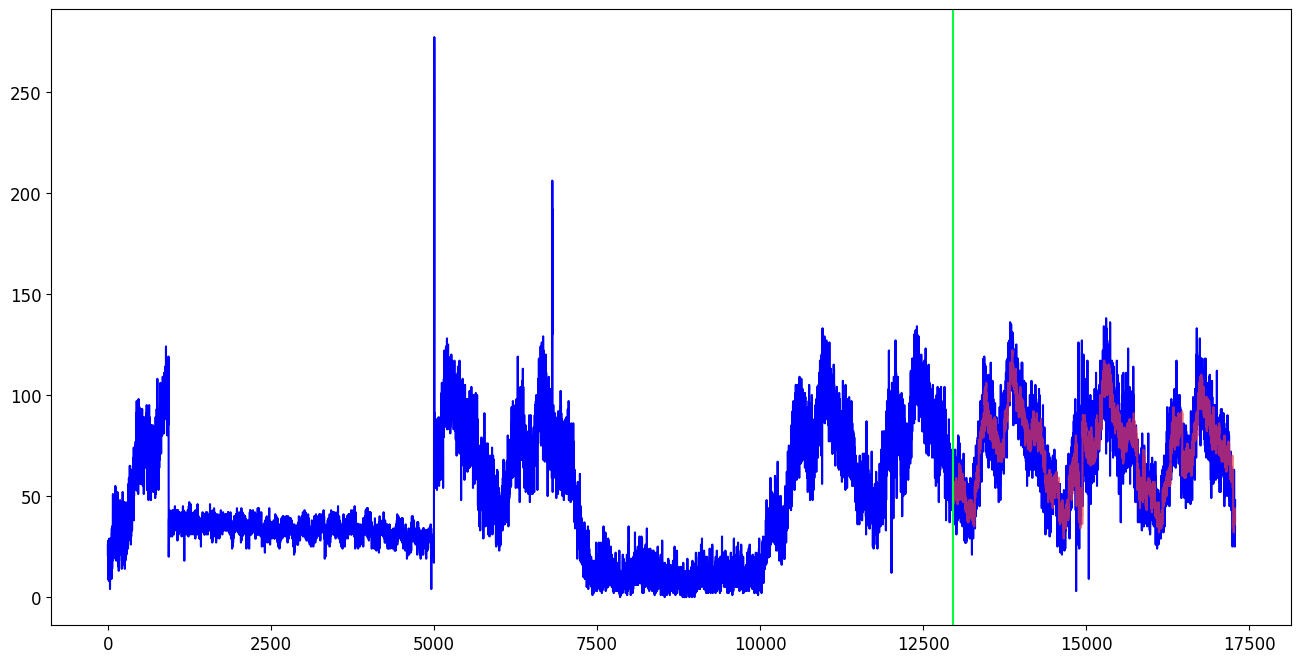

7c0e591a3aef826f584c4d19015d245d574571e8a31eda3b14667966288c2624	Type:Possible
CV:1.5295297829271997	PE:0.8605516295409282	Period:5040.0	Period_Strength:0.1900228175418201	CV_WT:1.8999969448297906
Predict Windows:60mins	MAE:0.07	MSE:0.018	RMSE:0.133	sMAPE:0.564


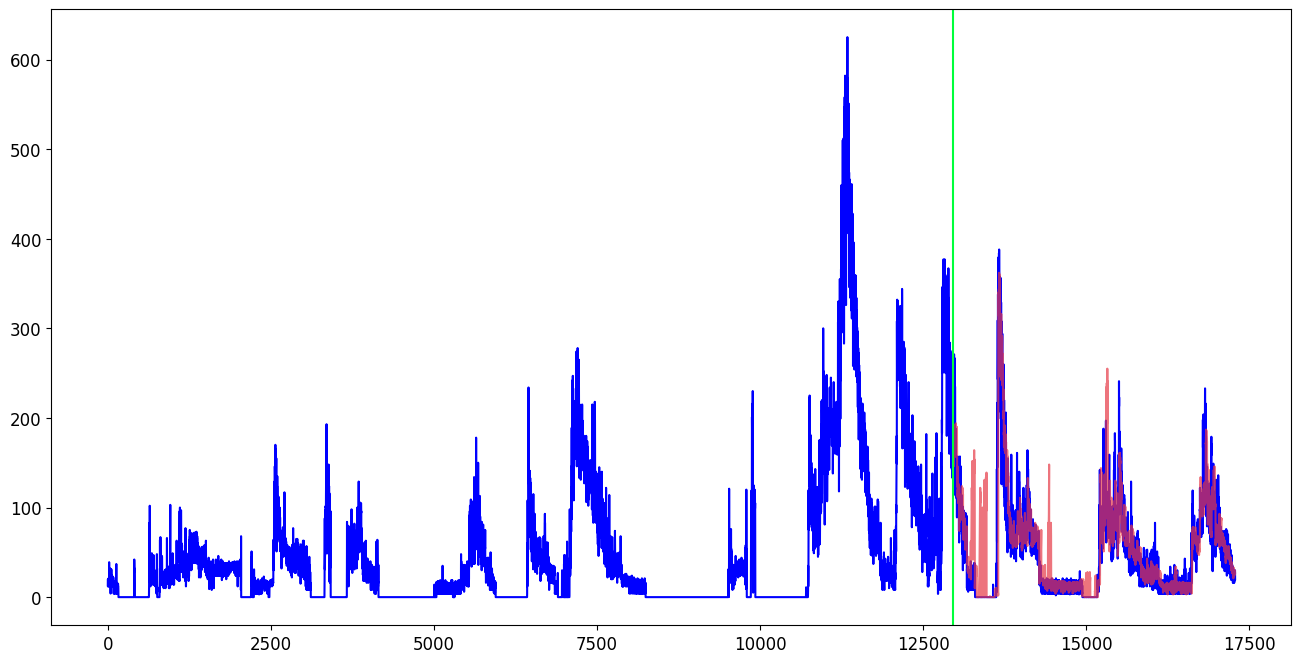

Predict Windows:30mins	MAE:0.053	MSE:0.009	RMSE:0.094	sMAPE:0.5


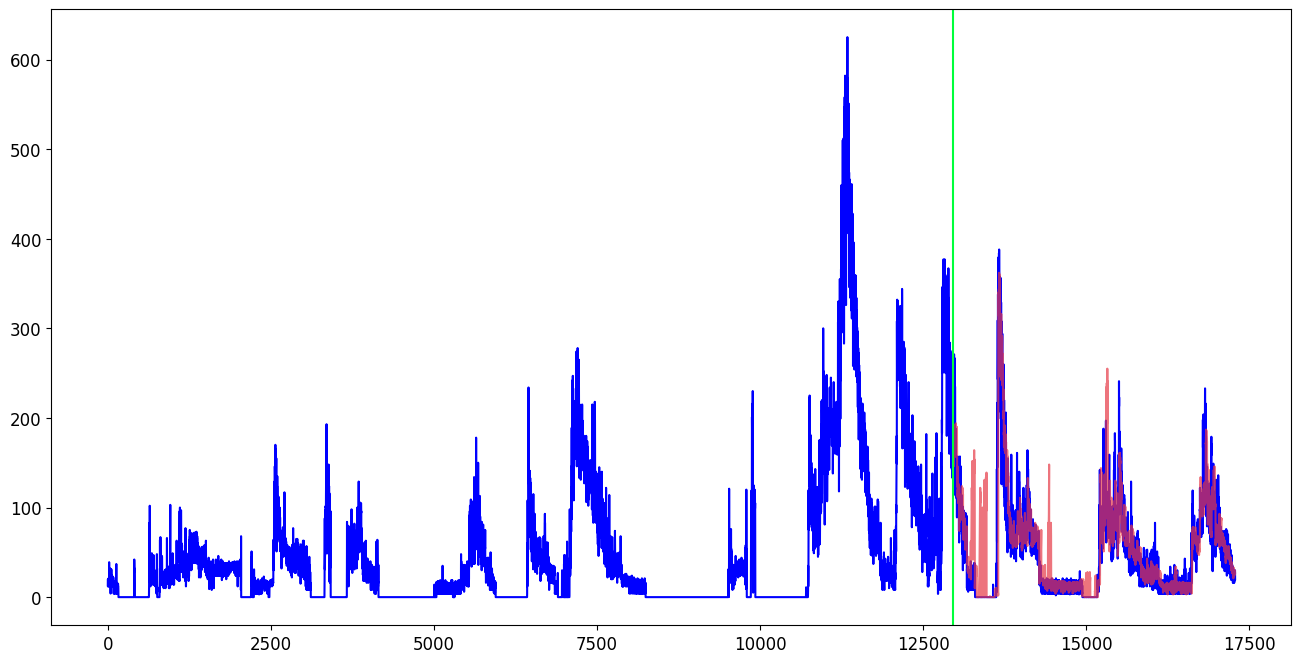

7f60d4c90d623b2d4d30b4df58f951c244637371ac93bcfd36374b7a82121f5d	Type:Possible
CV:1.026845919534875	PE:0.9907578534367755	Period:10080.0	Period_Strength:0.3444994032501842	CV_WT:3.2238458347361822
Predict Windows:60mins	MAE:0.071	MSE:0.018	RMSE:0.133	sMAPE:0.745


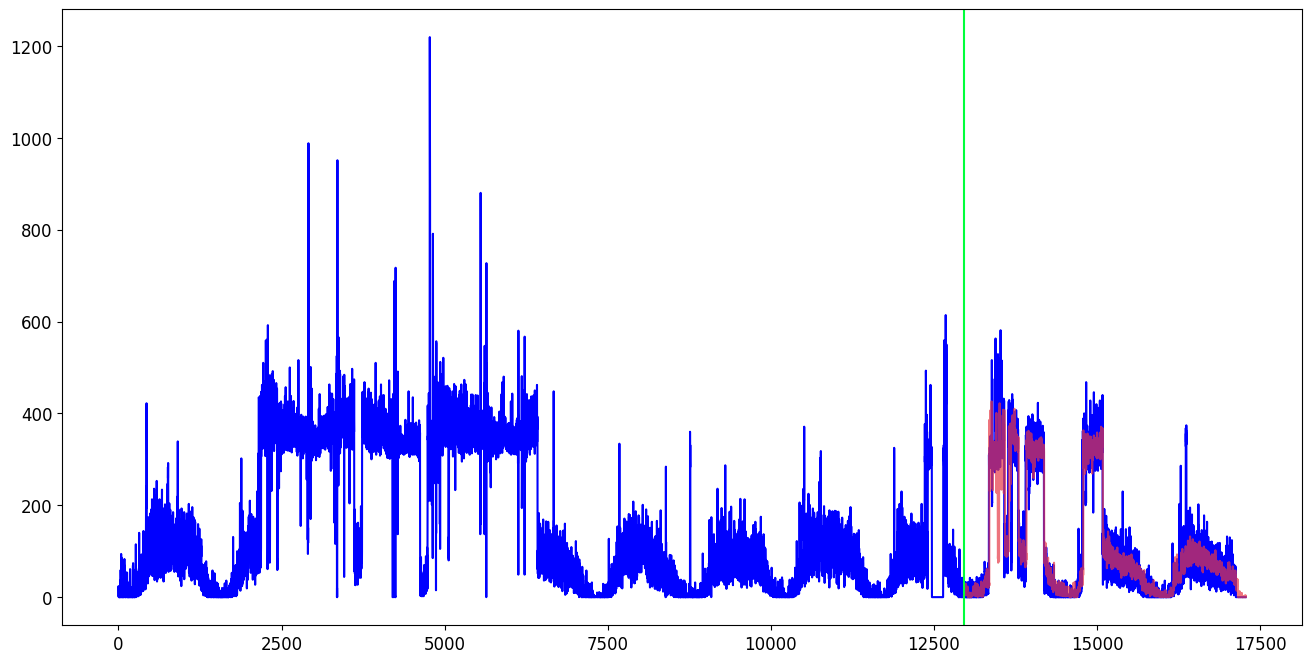

Predict Windows:30mins	MAE:0.051	MSE:0.009	RMSE:0.095	sMAPE:0.678


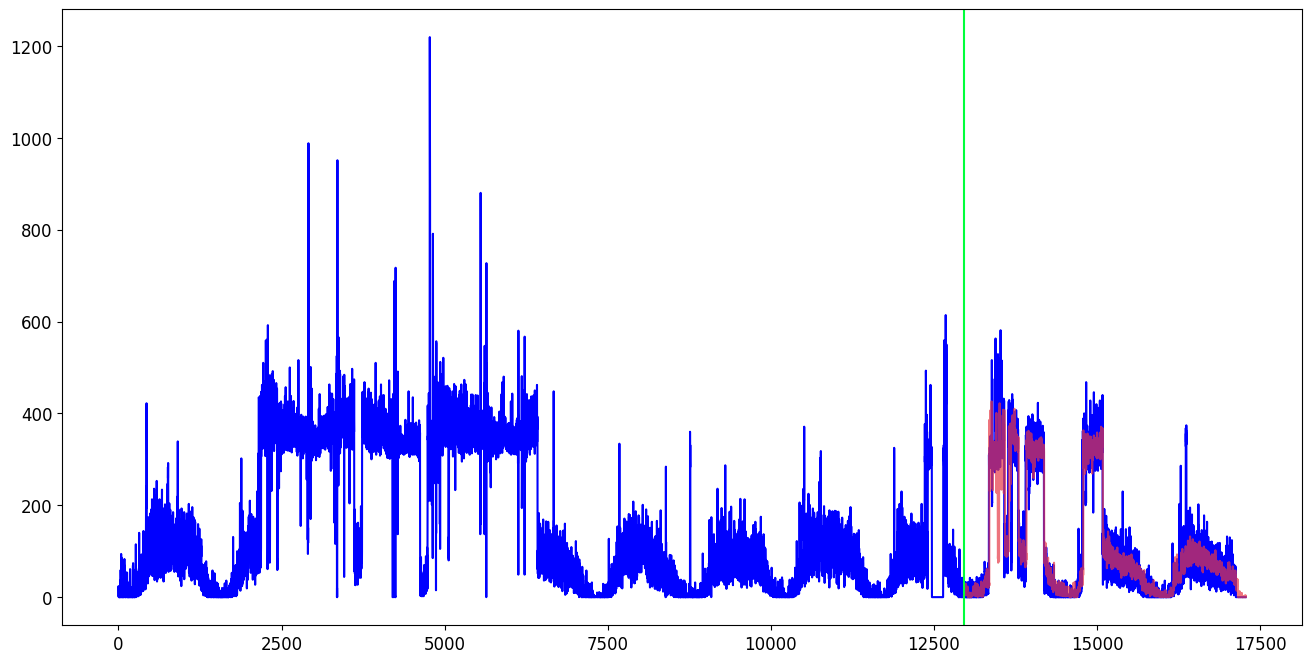

In [7]:
with open('specific_func_pred.pkl','rb') as f:
    pred_func_account = pkl.load(f)

with open('specific_func_pred30mins.pkl','rb') as f:
    pred_func_account2 = pkl.load(f)

for func in func_ids:
    scaler = MinMaxScaler()
    pred_result = np.array(pred_func_account[func],dtype=int)
    pred_result2 = np.array(pred_func_account2[func],dtype=int)
    
    arr = train_func_arrcount[func]
    # print(arr[:30])

    train_arr = np.array(arr[:1440 * valid_split_DAY],dtype=int)
    valid_arr = np.array(arr[1440 * valid_split_DAY:],dtype=int)

    valid_normalized = scaler.fit_transform(np.array(valid_arr).reshape(-1,1))
    pred_normalized = scaler.transform(np.array(pred_result).reshape(-1,1))[:4320]
    pred_normalized2 = scaler.transform(np.array(pred_result2).reshape(-1,1))[:4320]
    
    # 计算MAE、MSE、RMSE、sMAPE
    result_MAE = mae(valid_normalized, pred_normalized)
    result_MSE = mse(valid_normalized, pred_normalized)
    result_sMAPE = smape(valid_normalized, pred_normalized)
    result_RMSE = rmse(valid_normalized, pred_normalized)
    
    # 计算MAE、MSE、RMSE、sMAPE
    result_MAE2 = mae(valid_normalized, pred_normalized2)
    result_MSE2 = mse(valid_normalized, pred_normalized2)
    result_sMAPE2 = smape(valid_normalized, pred_normalized2)
    result_RMSE2 = rmse(valid_normalized, pred_normalized2)

    # 输出函数信息
    func_info = df.filter(pl.col('Function') == func).to_dict(as_series=False)
    print(func+'\t'+'Type:{}'.format(label_lst[int(func_info['Type'][0])]))
    print("CV:{}\tPE:{}\tPeriod:{}\tPeriod_Strength:{}\tCV_WT:{}"
        .format(func_info['CV'][0],func_info['PE'][0],func_info['Period'][0],func_info['Period_Strength'][0],func_info['CV_WT'][0]))
    
    print("Predict Windows:{}\tMAE:{}\tMSE:{}\tRMSE:{}\tsMAPE:{}".format('60mins',result_MAE, result_MSE, result_RMSE, result_sMAPE))

    # 画图
    plt.rcParams['axes.unicode_minus'] = False        # 显示负号
    plt.figure(figsize=(16,8))
    x1 = [i for i in range(1, len(arr) + 1)]
    x2 = [i for i in range(len(train_arr), len(train_arr) + len(valid_arr))]
        
    plt.plot(x1, arr, color="blue")
    plt.plot(x2, pred_result2, color="#e63946", label="Actual",alpha = 0.7)
    plt.axvline(len(train_arr), color="#00FF3A", label="Forecast")
        
    # 设置坐标轴刻度标签的大小
    plt.tick_params(axis='x', direction='out',
                    labelsize=12, length=3.6)
    plt.tick_params(axis='y', direction='out',
                    labelsize=12, length=3.6)
    plt.show()
    plt.clf()
    plt.close()
    
    print("Predict Windows:{}\tMAE:{}\tMSE:{}\tRMSE:{}\tsMAPE:{}".format('30mins',result_MAE2, result_MSE2, result_RMSE2, result_sMAPE2))

    # 画图
    plt.rcParams['axes.unicode_minus'] = False        # 显示负号
    plt.figure(figsize=(16,8))
    x1 = [i for i in range(1, len(arr) + 1)]
    x2 = [i for i in range(len(train_arr), len(train_arr) + len(valid_arr))]
        
    plt.plot(x1, arr, color="blue")
    plt.plot(x2, pred_result2, color="#e63946", label="Actual",alpha = 0.7)
    plt.axvline(len(train_arr), color="#00FF3A", label="Forecast")
        
    # 设置坐标轴刻度标签的大小
    plt.tick_params(axis='x', direction='out',
                    labelsize=12, length=3.6)
    plt.tick_params(axis='y', direction='out',
                    labelsize=12, length=3.6)
    plt.show()
    plt.clf()
    plt.close()